# Validate regridding of NSIDC G02202 sea ice product

Regridding done is seaice_g02202_reprojection.ipynb

In [18]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.

from imports import glob,xr,os,plt,np,xe,stats

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [14]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [15]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [16]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [1]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [4]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

Using the G02202 V4 product (recommended by Walt Meier) regridded to a 0.25x0.25 degree grid

In [5]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/latlon_gridding/'

In [6]:
g02202_files = glob.glob('%s/*monthly*.nc' % (g02202_path))
g02202_files.sort()

g02202_ancillary_file = glob.glob('%s/*ancillary*.nc' % (g02202_path))[0]

In [7]:
g02202_ds = xr.open_mfdataset(g02202_files,parallel=True) # this is slow, sometimes
g02202_ancillary_ds = xr.open_dataset(g02202_ancillary_file)

Check if the land fraction (1 - notocean) variable will even be of use. There is no overlap.

Text(0.5, 1.0, 'Product of first two plots')

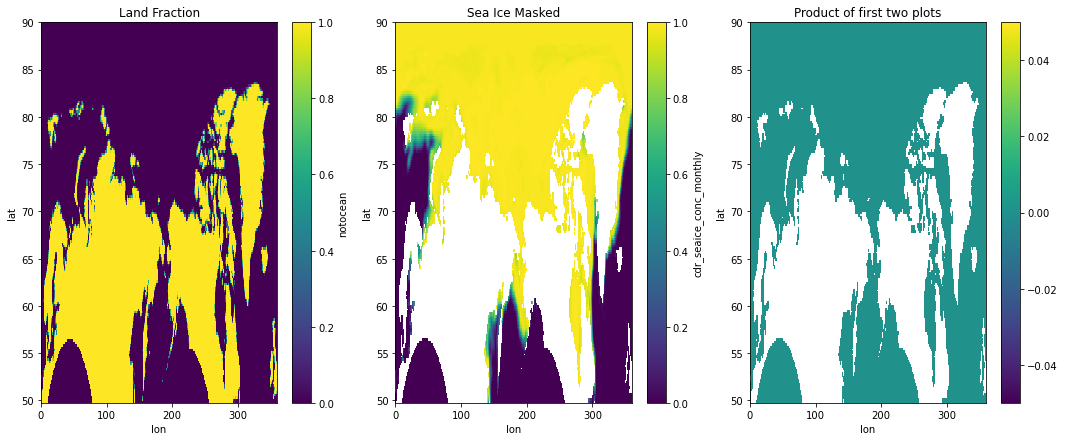

In [8]:
figs,axss = plt.subplots(1,3,figsize=(18,7))

g02202_ancillary_ds['notocean'].plot(ax=axss[0])
axss[0].set_title('Land Fraction')

g02202_ds['cdr_seaice_conc_monthly'][0].plot(ax=axss[1])
axss[1].set_title('Sea Ice Masked')

(g02202_ancillary_ds['notocean']*g02202_ds['cdr_seaice_conc_monthly'][0]).plot(ax=axss[2])
axss[2].set_title('Product of first two plots')

In [9]:
# Load into memory (slowish, takes up more space than I expected, 600mb?)
g02202_real = g02202_ds['cdr_seaice_conc_monthly'].load()

In [10]:
g10010_subtest = nsidc_seaice['seaice_conc'].sel(time=slice('2001-01-01','2017-12-31'),latitude=slice(None,60)).where(~(nsidc_seaice['LandRegion_mask']==20))
g02202_subtest = g02202_real.sel(time=slice('2001-01-01','2017-12-31'),lat=slice(60,None))*100

#### Validate G02202 regridding against the lat-lon gridded G10010 product

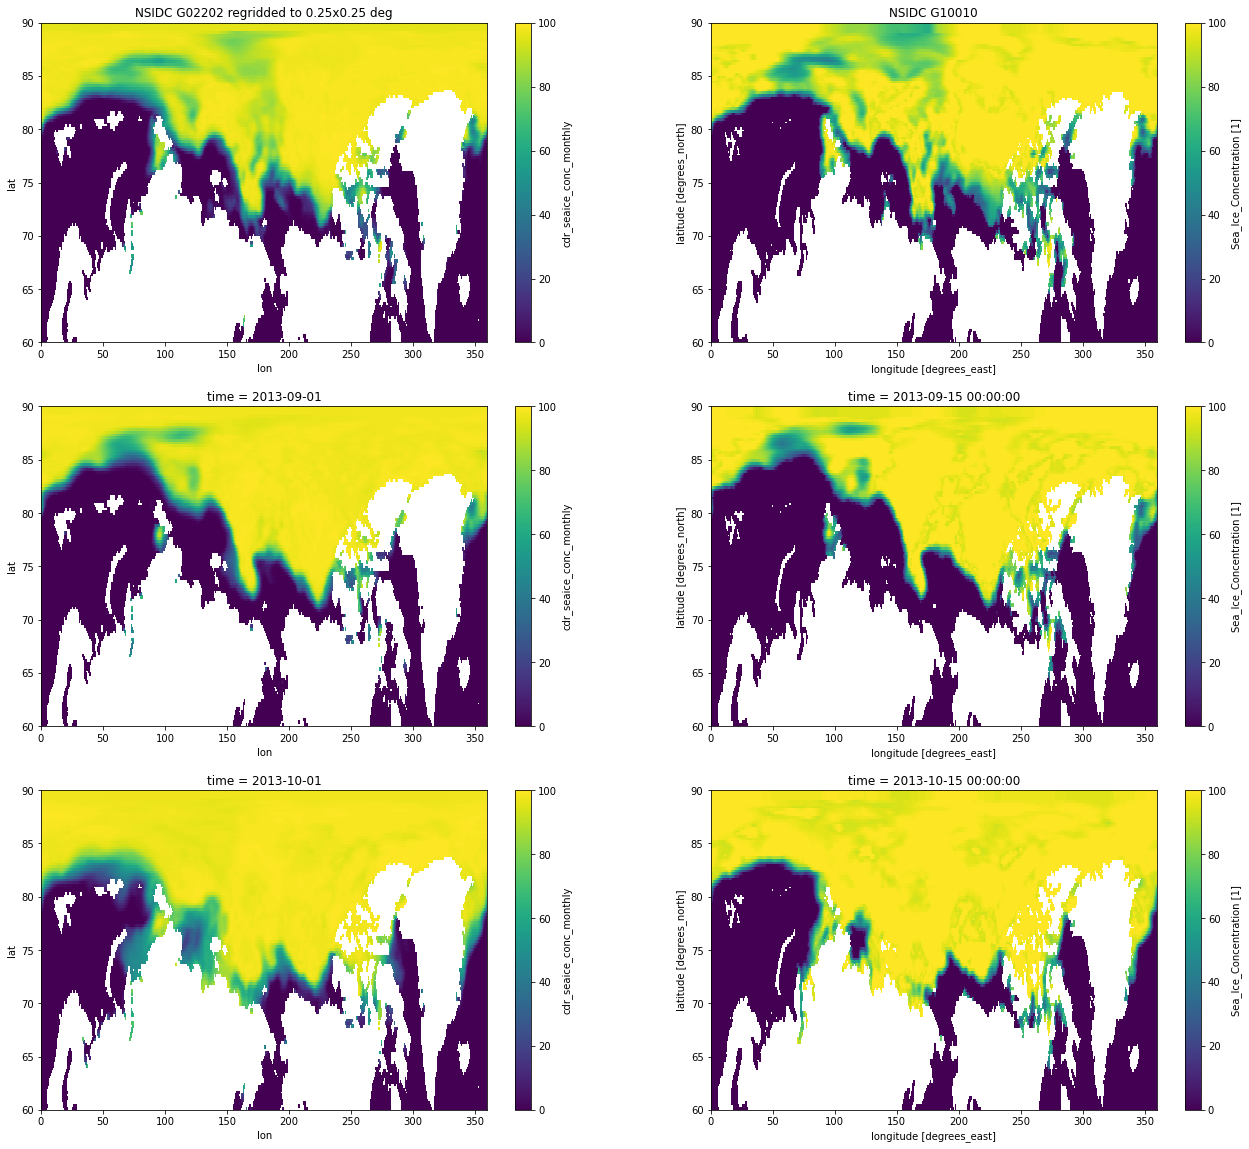

In [11]:
val_fig,val_axs = plt.subplots(3,2,figsize=(22,20))
val_axs = val_axs.flat

g02202_subtest[151].plot(ax=val_axs[0])
val_axs[0].set_title('NSIDC G02202 regridded to 0.25x0.25 deg')

g10010_subtest[151].plot(ax=val_axs[1])
val_axs[1].set_title('NSIDC G10010')

g02202_subtest[152].plot(ax=val_axs[2])

g10010_subtest[152].plot(ax=val_axs[3])

g02202_subtest[153].plot(ax=val_axs[4])

g10010_subtest[153].plot(ax=val_axs[5])

Generally, these match up. But finer features are somewhat blurred in the regridded product. Not sure if this has anything to do with the G02202 already being blurred, but it shouldn't be. I wouldn't really expect this behavior.

In [19]:
g02202_comp_trends,_,_ = compute_trends_n_signif2(g02202_subtest.mean(dim='lon'))
g10010_comp_trends,_,_ = compute_trends_n_signif2(g10010_subtest.mean(dim='longitude'))

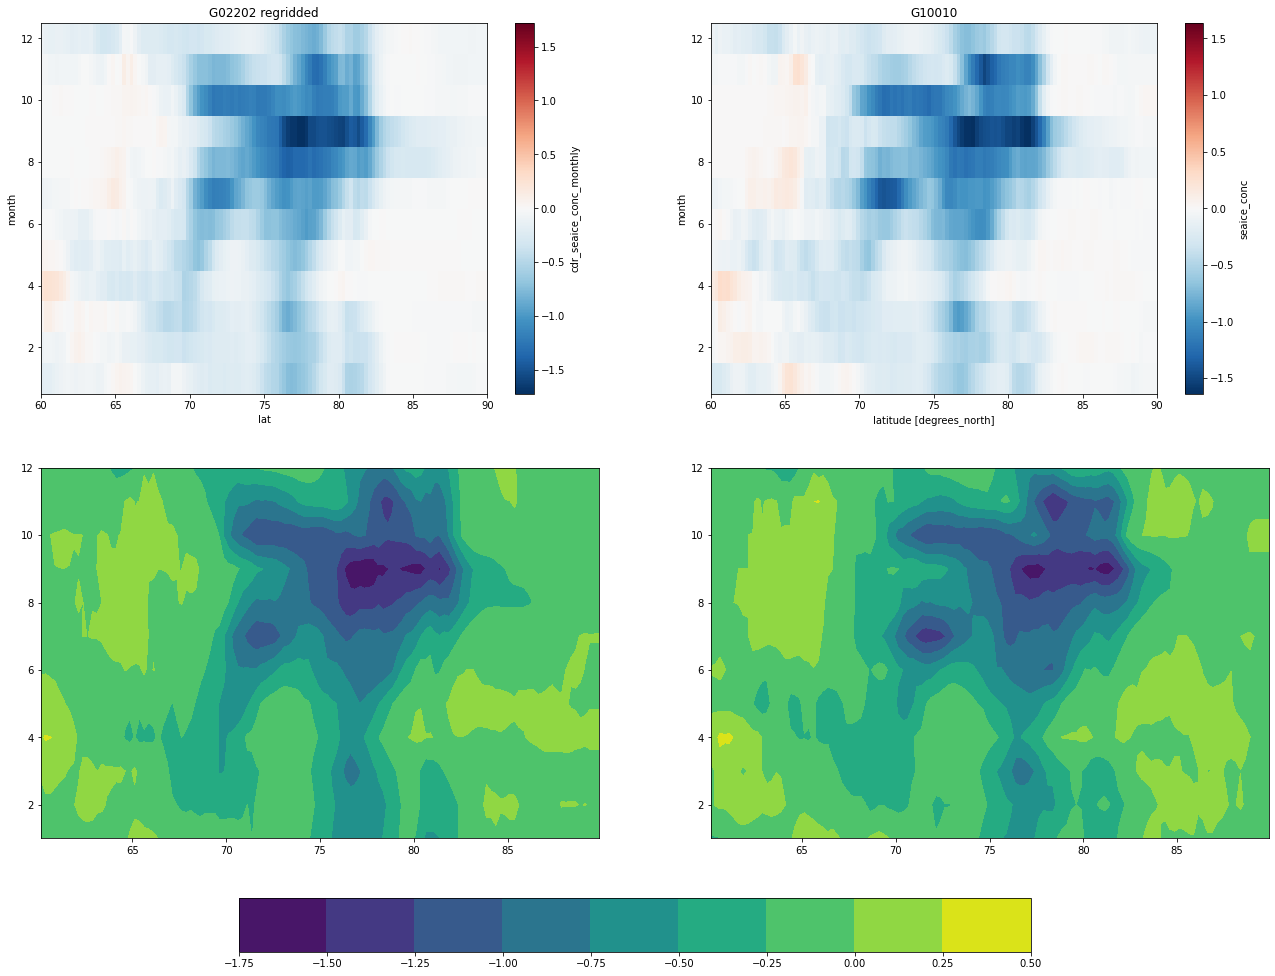

In [20]:
trendval_fig,trendval_axs = plt.subplots(2,2,figsize=(22,15))
trendval_axs = trendval_axs.flat

cbar_ax = trendval_fig.add_axes([0.25,0.02,0.5,0.05])

g02202_comp_trends.plot(ax=trendval_axs[0])
trendval_axs[0].set_title('G02202 regridded')

g10010_comp_trends.plot(ax=trendval_axs[1])
trendval_axs[1].set_title('G10010')

im0 = trendval_axs[2].contourf(g02202_comp_trends['lat'],g02202_comp_trends['month'],g02202_comp_trends,vmin=-1.75,vmax=0.5)
im1 = trendval_axs[3].contourf(g10010_comp_trends['latitude'],g10010_comp_trends['month'],g10010_comp_trends,vmin=-1.75,vmax=0.5)
plt.colorbar(im0data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABPsAAAPQCAYAAABAKH5MAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy86wFpkAAAACXBIWXMAAAsTAAALEwEAmpwYAADPfElEQVR4nOzdedwkZ1nv/+/1rPPMnmSyD5CASEBElsgiihBQMaIIAoJwROAcDioqRz1HPP4UwaMHFNTjQYFhS1hEEIjEQ2SRyKIIEnaygEAQJvtkmcxklmfp6/dHd09X3U93dXV37fV5v17zmqe6qqvurt6+fdV9V5m7CwAAAAAAAED9zZXdAAAAAAAAAADZoNgHAAAAAAAANATFPgAAAAAAAKAhKPYBAAAAAAAADUGxDwAAAAAAAGgIin0AAAAAAABAQ1DsA1A4M7vSzB49Yt6jzWx/wn0vMrP/NeV2p74vAAAAAAB1QLEPyIiZPd3MPm1md5nZzb2/f8nMrDffzOwVZnZr798fR+adZmbvMLPrzeygmf2LmT0ssu6fMLN/NrM7zOxGM3u9me2IzF82szeZ2Z29+b8emffdZvY+M7vFzG4zsw+a2X2K3Dchd/8ed/9omW0AAADAdJJyr5k9xsz+qZdpvzXkvuf05h8xs2vM7HHB/J8zs//orfvvzOzkyLynmdkne/f96JB1P9DMPtub/1kze2AODx8AKo9iH5ABM/sNSf9H0p9IOkPS6ZJeIOmRkpZ6iz1f0k9L+j5JD5D0BEn/tTdvu6TPSHqIpJMlXSzp/Wa2vTd/l6T/JeksSfeVtLe3rb7fl3RvSfeQ9BhJ/8PMHt+bt1vSpZLu02vXv0l63wSPbT7tsinWtZDVugAAAFC8FLn3LklvkvTfR6ziHZI+L+kUSb8j6d1mdmpv3d8j6XWS/lNvvUck/VXkvrdJ+nNJLx/SriV1M+7bJJ2kbp5+X+92AGgVin3AjMxsl6SXSfold3+3ux/yrs+7+zPd/Xhv0WdLepW773f36yS9StIvSJK7f9Pd/9Tdb3D3DXffp25Yuk9v/l+7+wfc/Yi73y7p9eoGqr6fl/QH7n67u1/dm99f97+5+xvd/TZ3X5P0Z5LuY2anjHg8F5nZa8zsMjO7S9JjzOwsM3tPr3fgtWb2q5HlV8zsYjO73cyuNrP/ER2Ga2bfMrPfMrMvSbrLzBZ6tz0ucv+Leve/StL3B+15kJl9zswOmdk7JW0J5j/BzL7Q6/X4STN7QNr7AgAAIL00ubeXPd8q6ZtD7v/dkh4s6SXuftTd3yPpy5J+prfIMyX9vbt/3N0PS/pdSU/uj2hx939093dJun5I8x4taUHSn/fa8ReSTNIFWe4DAKgDin3A7B4haVnje8t9j6QvRqa/2Lttk96QgyVJXx+xrkdJurK37Enq9vhLte7efW9091sT2vpzkv5Q0g5Jn5T09711ni3psZJeZGY/1lv2JZLOkXRPST8i6VlD1vcMST8habe7rwfzXiLpXr1/P6ZuUVS9x7Yk6e8kvVXdHo9/q0EYlJk9WN0jx/9V3aPDr5N0aW9Yc+J9AQAAMLG0uXeU75H0TXc/FLktmltjedndvyFpVdJ3p1z3l9zdI7d9SaMzMQA0FsU+YHZ7JB2IFrF6PczuMLOjZvao3s3bJR2M3O+gpO1m3fP2Re67U90C1UvdPbp8f/6PqFsQ+73Ievvri657hwJmtlfSX0r69XBe4H3u/i/u3pH0vZJOdfeXufuqu39T3Z6DT+8t+zRJf9TrVbhf0l8MWd9fuPt33P3okHlPk/SHvZ6H3wnu/3BJi+oeoV1z93erO9y5779Iep27f7rXI/JiScd79xt3XwAAAEwmbe4dJczDUjy3jps/y7oBoDU4fxYwu1sl7TGzhX7wcfcfkKTecNZ+Uf2wpJ2R++2UdDh69NHMVtTtRfcpd//f4YbM7OGS/lrSU9z9a5H19td3LPL3oeC+p0r6kKS/cvd3jHlM34n8fQ9JZ5nZHZHb5iV9ovf3WcHy0b+TbusL7/8fwbzrgiO00fn3kPRsM/uVyG1Lvfv5mPsCAABgMmlz7yhhHpbiuXXc/FnWDQCtQc8+YHb/qm5vsieOWe5KdS/O0fd9vdskda+oq+6w0+s0uHCHIvMfpO6FNp7r7h/p3947h98NY9Z9krqFvkvd/Q9TPKZogew7kq51992Rfzvc/cLe/BvUvWBI393GrC90Q3Cfuwfzzg56P0bnf0fdXoHRtm3tFTPH3RcAAACTSZt7R7lS0j375+DriebWWF42s3uqO2z4axrvSkkPCLLfAyLrBoDWoNgHzMjd75D0Ukl/ZWZPMbPtZjbXO+/etsiib5H062Z2tpmdJek3JF0kSWa2KOndko5K+vne8NkTzOz+kj4g6Vfc/e+HNOMtkv4/MzvJzM5Td3hrf907JX1Q0r+4+4uneIj/JunO3kU2Vsxs3szub2b9C2m8S9Jv97Z9tqQXTrj+6P33Sor20vtXSeuSfrV3YY8nS3poZP7rJb3AzB5mXdvM7Cd6AXLcfQEAADCBNLm3N71F3dOpmJlt6Z1LWb2RKV+Q9JLe7U9StyD3nt4m3i7pJ83sh8xsm7oXA3lv/xx/vRy6Rd0RanO9dSz27vtRSRvqZr9lM+tn0stz2yEAUFEU+4AMuPsfq3sevP8h6WZJN6l7sYjfUvcCF+pN/726Vxz7iqT3926TpB+Q9ARJPyrpDjM73Pv3Q735vyHpVElvjMyLHqV8iaRvqDtM9WOS/sTdP9Cb9yR1r3D7nMh9D5tZql5u7r4h6SclPVDStZIOSHqDpF29RV4maX9v3j+qW7Q8vmlFo7201+5r1e19+NbItlclPVndKwvfLulnJb03Mv8KdQubr+7N/7oGVyFOvC8AAAAmlyL3PkrdA9iXqTuq4qi6Ga/v6ZLOVzefvVzd09Pc0lv3lZJeoG7R72Z1z7f3S5H7/qfe+l4j6Yd6f7++d99VST8t6ecl3SHpuZJ+unc7ALSKxU9nBQCzMbNflPR0d//hstsCAAAAAEDb0LMPwEzM7Ewze2RvyMZ91O2FeEnZ7QIAAAAAoI24Gi+AWS2pO3TjXHWHTPyNpL8qs0EAAAAAALQVw3gBAAAAAACAhmAYLwAAAAAAANAQFPsAAAAAAACAhqjFOftOOWWP3+0ed+9OBKOOkwYh25j1Jt03HN1s41Y2gU5k3R60YpJR1WGTLGjkXGRyfmz7Bwt0gjZ1OvEl8xr4He6LWTaUVxvHvQ4s4VU3yUtoktfbLC/NcD+Frz+P/Z38Wg2nNyI3rHd85DxJ6kSmw9dbqOOj25E0T4rv14W5+J5bnJ8LpsP302B683svbOPg741O8qsx3Bejttmdjs9fnIu3eT6yQLhsUpvHv4ZGr8wyPBWEhzsycdWjZzbh5BRf+PznD7j7qUVt72624sc05s2X0gGtftDdH5/JyoASxHKn4t8lm76fx3zgxL5Hx2TLST5ON39/p/9MDL8rk5adCz7/o98z4a4Iv3fC6U7CfkzKH5u+oyZ4DsJZ477vxnxlp93s+MyUtKIx399RYU5IWnZ8hk25onEmjPPRfbPpdZ2wH5NypyStBU9mJzIdLpv03tv8ug72ecJreX4uOcfNR+4cLjvJ79hxnx3hfuwk7POkNo7LpZuz50Rhc7Bo+Pxk+UM8tuLs7pBl9ow+2rHvn4y2+cWa5k4yZ7JaFPvudo+76/KP/bOkzUWDpJfIuG6L0ftu+sIItpNUSBsXDMIPvmPrgy2vBnde3Uj44b8pcMXnh8WLlYXBAruW4wuHW4l+kEfbJ0lH1uLTYZunFa4m/OLdSHhykwLksHXFvnjHfGFE7xsuuzCfeNf4l/aE4WDUerr3jc+Pzg5f5+FrNSr8MRC+3MLXffS5DkNT+FpdXY9PHzy+duLv24+uBfPWY9NH1jZO/H10dSM2L2xTOH818no9Hrx2V4Pppch7YvfWxdi8s3ZtiU2fsSM+vXVxcN+wyBYWBqPtuC147KE7g30RtbIYf8HtWIpPn7ZtOTa9c3kwP9peSVoK2hidPS5gJr12xxb7PPIcWPKnchjmkla9qbAbm5fcpLyMOwdu0nsztHv71v+YtT2TOKaOfkZnZrKu1+k/9mSyIqAk0dwpxb8Ll4LPy4TY1psfOfC1kZwtJylAhN/BSQeOwu/vu4Lv0ajws3V5Pv69s2vLYHpL8L2yvBD/jN+yEJ9/LJITgq+oIY9n8HeYb8dlwOhncfj8hOsKRb+/wxgafoOF+zUqzMrrwS5fixzZDPNumO/nYtky3v6ti+F3e8JB5+C+m7YTmzdZ4SlqU7Yc87qO5rxwv4X7OLofw98r0dwpSTfftRqbPhzJW2H2CvNi1EqQvbYF2Sw8WLwWeUJ3bolnzTDHbV8a/BTfvRL/WT7u90r0N/HamA+itU74226wI8OXcZgfdy0vRuYFvzWDZVeCz4Do63GijgwFFfsmPV4d/XwM7zru4H6SSeoMYdbcNH/KNuzZua2WuZPMmawWxT4AAJAfU5oe4Ck1oWslAAAAcpFZ7iRzJqLYBwBAy3VDV0bVPoIXAAAARsgsd5I5E3GBDgAAAAAAAKAh6NkHAACyG8YLAAAAJCB35o9iHwAALZfpMF4AAABgBHJnMRjGCwAAAAAAADQEPfsAAGg7YzgFAAAACkDuLATFPgAAWo7hFAAAACgCubMYDOMFAAAAAAAAGoKefQAAtFz3CGvZrQAAAEDTkTuLkVvPPjN7k5ndbGZfidz2J2Z2jZl9ycwuMbPdeW0fAACkZZq3bP4BZSB3AgBQF8VlzmH5IJj/aDM7aGZf6P37vUwfaonyHMZ7kaTHB7d9WNL93f0Bkr4m6bdz3D4AAADa4SKROwEAQNxF2pwPQp9w9wf2/r2sgDYVIrdin7t/XNJtwW0fcvf13uSnJO3Na/sAACAdUzcQZPEPKAO5EwCAesgqd6YxLB+0RZnn7HuupHeOmmlmz5f0fEnae7e7FdUmAABaiSG4aDhyJwAAFZFR7txjZldEpve5+74p1vMIM/uipOsl/aa7X5lF48pWSrHPzH5H0rqkt49apvck7ZOkBz74wV5Q0wAAaB0zTpSM5iJ3AgBQHRnmzgPufv6M6/icpHu4+2Ezu1DS30m698wtq4DCR9yY2bMlPUHSM92dMAUAAIBckDsBAMAo7n6nux/u/X2ZpEUz21NyszJRaM8+M3u8pN+S9MPufqTIbQMAgNEYxoumIXcCAFBNVcmdZnaGpJvc3c3soep2iLu15GZlIrdin5m9Q9Kj1R1HvV/SS9S9CtqypA9b98n9lLu/IK82AACA8UwM40W9kTsBAKiHInPniHywKEnu/lpJT5H0i2a2LumopKc3ZSRAbsU+d3/GkJvfmNf2AABA9ZnZm9QdVnmzu99/yPxHS3qfpGt7N73X3V9WWANRS+ROAAAQGpEPovNfLenVBTWnUGVejRcAAFRA9whrYV37LlI3VL0lYZlPuPsTimkOAAAAilJw7mwtin0AAKCw4RTu/nEzO6eYrQEAAKBqOH1M/gq/Gi8AAMAYjzCzL5rZP5jZ95TdGAAAAKBO6NkHAEDLmWU6nGKPmV0Rmd7n7vsmuP/nJN3D3Q+b2YWS/k7SvbNqHAAAAMqTce7ECBT7AABAlsMpDrj7+dPe2d3vjPx9mZn9lZntcfcD2TQPAAAAZWIYb/4YxgsAACrDzM4w6x7uNbOHqptVbi23VQAAAEB90LMPAICW614VraBtmb1D0qPVHe67X9JLJC1Kkru/VtJTJP2ima1LOirp6e7uxbQOAAAAeSoyd7YZxT4AAFrOZIWdO8XdnzFm/qslvbqQxgAAAKBQRebONqPYBwAAOMIKAACAQpA788c5+wAAAAAAAICGqEXPvjlJS73S71JQAt5IOItPeIofy7CraLQZ83PJ693oxNuxdXFu5Lzw4SxE1r0clGatsx6b7swvxudHHv/c0dvj21naFl927eiJv7cF81a2xtcbtnk9Mn14taMk4/ZVVLAZHd8YrHt1Y3QbJOn4erwdtx1dO/H37cfWYvMOHovvxzuD+UlWg+0cXd048fckj3VpIf7kbt8Sf2suzcfnL0eW374UX3bXcnx6S2TZ5WA7YffpuYT3yGLw3gvvu2UhmD8Xf91ErQXP16Hjg+fgljuPx+bdetdqbPrmO4/Fpm+7bfDaPRYse1ewLo9sdzHYTys7lmLTO09aiU3viLwPti7Nx+bd+/Qdsenoc39z0IbwvvtvPxKbXloYzN8btOHsYDp8vrYsbDnx98qCJy4bbWP4XE7yUenjFrb50bPGnIYtuupw0fDxdCILhEcKw62Eny2xZWc4NVyW3zFFM9v8OgDaak7x77xo9kz6npzUxpjPm+h7cs43YvN8Lv4dFvs89SCLWfy7fy3YbJjrolY8/r0qi6w7WK+tHY5Nz996U2x6a2dwX1/cEpvXCbJnZ+tJg2Xn4ts5eDy+LzaChxuNX+HTFX7GrwX3jU4eXw+XHb2fFoPMN6f49ML86O2udeKNCLN09HVyeDX+2I8FObQTPr5IXg7nhaKPYSHInTuC7LJ1MT4dzZeLwfM1Lj8mfdeHz1/0vbgStGF78EMpbON1kfx4+9F41r/mhkOx6W/dNJg+FMmZknRnMH3ktlvi07ded+Lv5R0nx+Yt7zo1Nr24ZfA+2LYz/p5YXI63fz54ThaWRuer8L4bwetkLXgPRW3ZFs/v50Qy7vecvTM277tOib9v73Xy1tj0KSuDz6ntS/H2h7/prTO6TZZl/6TI5+OmT/PgMy3MuAvhZ2vEYvD8dIK1j/u8jzUj8vem3m8NyWrkzmLUotgHAADyw4mSAQAAUARyZzEYxgsAAAAAAAA0BD37AAAAwykAAABQCHJn/ij2AQDQcgynAAAAQBHIncVgGC8AAAAAAADQEPTsAwAADKcAAABAIcid+aPYBwBAy5lJc4QuAAAA5IzcWQyG8QIAAAAAAAANQc8+AABaz2ScKRkAAAC5I3cWgWIfAABtZ9IcoQsAAAB5I3cWgmIfAAAtZ5JsnjN7AAAAIF/kzmKwhwEAAAAAAICGoGcfAABtZ+LcKQAAAMgfubMQFPsAAGg7M86dAgAAgPyROwvBMF4AAAAAAACgIejZBwAAZHMc/wMAAED+yJ35o9gHAEDLmYnhFAAAAMgdubMYlFMBAAAAAACAhqBnHwAA4KpoAAAAKAS5M38U+wAAaDsz2Tyd/QEAAJAzcmch2MMAAAAAAABAQ9CzDwCAljNxomQAAADkj9xZDIp9AAC0nUk2R+gCAABAzsidhWAYLwAAAAAAANAQ9OwDAKD1THOcKBkAAAC5I3cWgWIfAABtZ5Jx7hQAAADkjdxZCIp9AAC0nBG6AAAAUAByZzHoOwkAAAAAAAA0BD37AAAA504BAABAIcid+aPYBwBA25kxnAIAAAD5I3cWoh7FPjPNzw1/McyHi7pHp+IzvRMsnL6a7Db9i3HBRk/7mIp2/PGEbYrf1zobo5dd2pa4HV/YEpmI76e5jbX4doLtLtpg+S0r8ZdUJ3gONiKPZ3Uj/tg6ox+qJGn70mDd4X2PrsfbfHw93sYbDh8/8fdNkb8l6Zs33xWbvvHg0RN/33p4NTZv7fh6bPrYXfF9c+zIYHpuzAfY/MKgjR48+E4wHV1WkjYij3cueG9YMD0feY11gtdT+Hgs4XUetmFxOf5cL6+M/jgJH9/CYvydu7w0mF4KtrMaPrer8dd5dD9v370lPi9Y13rkvuF+C9t48NYjsek7bx8svxQ89kPH4vsxfAxRp2xfTrzvRmfwGlpZiu+n7Vvi2z2+M75vOvLI33Hh+ys6Pe67NuFjSDN8NI79XE3a7iTCrYSPN7aZoE2TPLy5WXYGgMowSYsj384ZfTBJGhFth28rzHyJH8zJ2XIx+IZYjCxum7JymLSjzYsv6/NLsen1XWenbqN11kfO3wi+wFaC79hwP0YnD6/F2xjEx1guleLfO+FHerjsHUcHbf7KzYdi8w4ejefDa26Iz19dH+SRm++M59LjwX2PRrLo2vGNxGXDDBjNKxtBnkrKlovL8ec9zEyrQTui88MM2wm2u74Wv+/SyuLI7YSWIllzectibN588IMrzKm7tg6WD7PYaTvi0/c8dfC76XCQ0269K/7bYP9tp8WmD952zxN/h4816fkJM7gHr7dwfvQ5WhqTF8P3UHQ6zKyn7Yxn6fPO3HHi7+8/e1ds3t6d8f22cym+rqXIb5Dw/ZT4GTap8HMrtqG5kdNhDt3UpGDakz4PA+FvrvmEjBgum1DN2FQTCX//b/oMR6vVo9gHAAByYxr/IwsAAACYFbmzGBT7AABoO5OMc6cAAAAgb+TOQrCHAQAAAAAAgIagZx8AABh7nlEAAAAgC+TO/FHsAwCg7bgqGgAAAIpA7iwEw3gBAAAAAADQKGb2JjO72cy+MmK+mdlfmNnXzexLZvbgotuYF3r2AQDQcsaJkgEAAFCAgnPnRZJeLektI+b/uKR79/49TNJrev/XHsU+AADAuVMAAABQiKJyp7t/3MzOSVjkiZLe4u4u6VNmttvMznT3GwppYI4o9gEA0HYm2RzFPgAAAOSsWrnzbEnfiUzv791GsQ8AAAAAAAAo0B4zuyIyvc/d9024jmFVR5+hTZWRW7HPzN4k6QmSbnb3+/duO1nSOyWdI+lbkp7m7rfn1QYAADCeyTTHOftQY+ROAADqIcPcecDdz59xHfsl3S0yvVfS9TOusxLyTPYXSXp8cNuLJX3E3e8t6SO9aQAAUCaTbN4y+Td2Uy2+KhpydZHInQAAVF9GuTMjl0r6+V7+fLikg004X5+UY7HP3T8u6bbg5idKurj398WSfjqv7QMAgEq6SJuLMlHRq6I9X92rogGJyJ0AACBkZu+Q9K+S7mNm+83seWb2AjN7QW+RyyR9U9LXJb1e0i+V1NTMFX3OvtP7VVJ3v8HMTit4+wAAIGSSFTSMt81XRUPhyJ0AAFRNsbnzGWPmu6RfLqQxBavsBTrM7PnqHtHX3e52tzFLAwCA6ZlsLrPQNevJkht7VTRUF7kTAICiZJo7MULRe/gmMztTknr/3zxqQXff5+7nu/v5e049tbAGAgCAmRzof3/3/nFVNJRlqtx56p49hTUQAAAgD0UX+y6V9Oze38+W9L6Ctw8AAAJm0tz8XCb/MtDYq6KhcOROAAAqJqvciWS5DePtnQjx0eoO59kv6SWSXi7pXWb2PEnflvTUvLYPAADSssLOnZLCpZJeaGZ/I+lhatBV0ZAfcicAAHVRqdzZWLkV+xJOhPjYvLYJAACqbURRZlGS3P216l4V7UJ1r4p2RNJzymkp6oTcCQAAMFDZC3QAAICCcFU0AAAAFKHA3NlmFPsAAGg9rooGAACAIpA7i0CxDwCAtjPJ5ufLbgUAAACajtxZCMqpAAAAAAAAQEPQsw8AgJYzrooGAACAApA7i0GxDwCAtjNpjnOnAAAAIG/kzkKwhwEAAAAAAICGoGcfAABgOAUAAAAKQe7MH8U+AADazjh3CgAAAApA7iwEexgAAAAAAABoCHr2AQDQcibJOFEyAAAAckbuLEbjin1uNnqmzRfSBnPPZdnNdw7eIN5JvayH901a7xhJ6wqfjqXO+uBvbcRnzsUXXptbim8n8veWhfiyc0EbtszH9+vDz95x4u+HnLkjNs/vG192tTOYXuvE520Eu/joWvyG24+tDe4bLByu69j6YP56sOyRtfi+uSuYPnhksJ07In9L0sGj8enDkTbdeng13v5gemM93o6NSLvWjq/H5q0dj7fp8B3HYtN3Hjg4aP8t347NO37wQGx6/fhRjbKxOnqeJM0vrZz4e+spZyUvuzxYdm4u+fNgYz2+b7wzeLydtfi8zqZlB/ttedee2Lzl7Scn3vf44dtO/P3l3WfE5m3dvTs2vefsnbHpM07bduLv+5+9Kzbvnnu2xaZPWlkcrHcxvi+Wg271i/Px99ti5Mt5aSGcF59eiEwHszSf9HkdCBdN+pSyMesNRw0krWs+aHS45vjs+Ht8XDsqheEUQHMl5cNw0XEZMDo/WK911oNlg+/ZhMzrC8tpmidJCr6SdHR99HpvPBzPRHNjPpej31mrQTYLM+Cp2wbfoz9yr1MS1+vfE/8+vzOSobYsxPf5QsJuu2s13ojjG/EsFraxk7DPw6wZnT4S5NuDx+P78bYgPx4+Nnjubz50PDbv0LH4fTeCPLwayZ5Hggx7/Gj8NdWJLHvXnfHcGebQuw7cGJs+dvCWwXoP3x6bt370sEaJ5j9J2rLr1Nj04tZ4FptbHPx+sSBrzi8Ev20i6w6XXQ/yb1IbN1bjj31uYTE2ffxQ/PEmZeuVk4LsGcnW2087OzbvlOA31T3vHs+eD7jb7hN/n7Yj/h7fEmSOlUgW3bEcL1FsX4rvmzC3LkU+FJbmwxwaf70lZc8wp4aiqw4zXnjfzXlx0I5x+TCpHeFb2oPP2U5dBm6SOwvBHgYAAAAAAAAaonE9+wAAwISMq6IBAACgAOTOQlDsAwAAmiN0AQAAoADkzvyxhwEAAAAAAICGoGcfAAAtZ2ZcFQ0AAAC5I3cWg2IfAADg3CkAAAAoBLkzfxT7AABoOzNCFwAAAPJH7iwEexgAAAAAAABoCHr2AQAAzp0CAACAQpA780exDwCAljMzzc3Pl90MAAAANBy5sxiUUwEAAAAAAICGoGcfAADgRMkAAAAoBLkzfxT7AABoOyN0AQAAoADkzkKwhwEAAAAAAICGoGcfAACtZ1wVDQAAAAUgdxaBYh8AAC1nDKcAAABAAcidxWAPAwAAAAAAAA1Bzz4AANrOjCOsAAAAyB+5sxAU+wAAAOdOAQAAQCHInfmj2AcAQNuZyebmy24FAAAAmo7cWQjKqQAAAAAAAEBD0LMPAABIHGEFAABAEciduaPYBwBA65nEuVMAAACQO3JnEdjDAAAAAAAAQEPQsw8AgLYzyeYZTgEAAICckTsLQbEPAIDWM86dAgAAgAKQO4vAMF4AAAAAAACgIejZBwBA25k4wgoAAID8kTsLQbEPAICWM5mMq6IBAAAgZ+TOYrCHAQBA45kZh5ABAADQCvTsG8HcY9Nulvq+4bLhupLv3Anu2xk5T52N+LKd9fiq5iJPr8Xrup2Fxdj0WmfQRu/E22vB45kPdsX83Oh9Ez72jbnIdufibeiEywa7LbqZ1WBmOB22cS2y646sxffjXWvx/bj/zuMn/r71yGps3qHV+D4+eGQtNn342GD+0kL6Wnq4D1fX4208shpv4+Hj6yOXDbcbnd6+Jfktv3Y8/vg21gf7dS54HWxsdIJl49MrO7YN7rvwXbF52069e2zaIt24F5eXEtsYmovsu8Xl+OMLH89cZF/Mz8f308JSfDqcv7SyOHLe8kp8u8tLg8dzyvb441lZii+7Ebzf7oi85paD5/J4sI9P2b4cm9570sqJv8/atSU2b2ewb7ZH2rhrOf5eXFqIP9eLSe/xYFb4cbfeSfr8S//ZGG5nPuFzKXh6Ni276SM5dl8bNUtS/HNocxuTvyfCz6VKacdwiq+b2bslvdndryq7McA4sVwXZL5NmTCa84L3sgcZMMyE0XXZRjzX2EY8B9nqkZFtSsyhknx5kAt8If4ddft6vE0ebVPw2bmU9EEcCLPLuO+S1Ui2uelw/LGH3w9LC4Pv9yASaSP4ojl4LL5vrrrl8Im/j63H92OYC45GMuCtQZu2LsWf6/C+K5H543JpUp4/HLQ/XDaaL8N5u1biGeNokLuPRrJ1eN+FxeDxRXLQwrHgdR7s8+WVu8XXda97DJYNnq/1IGdH8+Jc0KbF5eTvyvXI4wvzoiU8vvCxzgdZLLzv7h2DDBjmwZVgXYfDfN8Z7ID5Mb2ros9J+Fzu3hqfDrPnSZHlTwruG2bPbZEcvjA3OuNJm9Nj9GUfxs4wh25o9G+bcDthrou/v5J/tyYJP4e2BBuOPv7wPbHeCWoFE9QoKqUdubN09OwDAKD1eldFy+JfdT1A0tckvcHMPmVmzzeznWU3CgAAoF0yyp1ptmT2eDP7qpl93cxePGT+o83soJl9offv9zJ/uCWhZx8AAGj8uVPc/ZCk10t6vZk9StI7JP1Zr7ffH7j710ttIAAAQEsUkTt7p3D5S0k/Imm/pM+Y2aVDRnh8wt2fkHuDCtbsZA8AAKBu4DOznzKzSyT9H0mvknRPSX8v6bJSGwcAAICsPVTS1939m+6+KulvJD2x5DYVhp59AAC0nVlhQ3DN7PHqFtvmJb3B3V8ezH+0pPdJurZ303vd/WUZbPrfJf2TpD9x909Gbn93r6cfAAAA8lZc7jxb0nci0/slPWzIco8wsy9Kul7Sb7r7lUU0Lm8U+wAAaL1iQlfJwyke4O6Hh81w91/NeFsAAAAYKrPcucfMrohM73P3ffENbRJeTuVzku7h7ofN7EJJfyfp3lk0rmwU+wAAQFFODKeQJDPrD6fI7eq4ZvZ/1Qt2w65aR6EPAACglg64+/kJ8/dLil6ae6+6vfdOcPc7I39fZmZ/ZWZ73P1Atk0tHsU+AADaziSbz6xnX9JR1jKGU1wxfhEAAAAUItvcmeQzku5tZudKuk7S0yX9XKwpZmdIusnd3cwequ51LW4tonF5o9gHAEDrmZTdVdGSjrIWPpzC3S+e9r4AAADIWqa5cyR3XzezF0r6oLrnin6Tu19pZi/ozX+tpKdI+kUzW5d0VNLT3T3MprVEsQ8AABSltOEUZvbdkn5T0jmK5B93v2CW9QIAAKCa3P0ySZcFt7028verJb266HYVgWIfAABtZyrqqmhlDqf4W0mvlfQGSRsZrA8AAACTKi53tlopxT4z+2+S/rO6Q3e+LOk57n6sjLYAAACTFRC6Sh5Ose7ur8lgPagZcicAAFVSTO5su8KLfWZ2tqRflXQ/dz9qZu9S98j+RUW3BQAAFKvo4RRmdnLvz783s1+SdImk45Ht3ZbVtlA95E4AANBGZQ3jXZC0YmZrkrYqOF8PAAAoWAEnSi7JZ9Xt0dW/OMh/j8xzSfcsvEUoGrkTAIAqaW7urIzCi33ufp2ZvVLSt9UdnvMhd/9Q0e0AAAA91tzhFO5+riSZ2ZZw6KaZbSmnVSgKuRMAgIppcO6sksLLqWZ2kqQnSjpX0lmStpnZs4Ys93wzu8LMrjhwyy1FNxMAgBax7omSs/hXXZ9MeRsaZJrcecuBmS78DAAAEmWUO5GojL6Tj5N0rbvf4u5rkt4r6QfChdx9n7uf7+7n7zn11MIbCQAA6s/MzjCzh6g7jPNBZvbg3r9HqzukE802ce48dc+ewhsJAACQpTLO2fdtSQ83s63qDqd4rKQrSmgHAACQumeza+65U35M0i9I2ivpTyO3H5L0P8toEApF7gQAoEqanTsro4xz9n3azN4t6XOS1iV9XtK+otsBAAC6TCabb+ZwCHe/WNLFZvYz7v6estuDYpE7AQColibnziop5Wq87v4SSS8pY9sAAKCV/p+Z/ZykcxTJP+7+stJahEKQOwEAQNuUUuwDAAAVYmrDiY7fJ+mgpM9KOl5yWwAAANqpHbmzdBT7AABoPWtD6Nrr7o8vuxEAAADt1orcWTrOiggAANrgk2b2vWU3AgAAAMgbPfsAAICs+VdF+0FJv2Bm16o7jNckubs/oNxmAQAAtEsLcmfpKPYBANB21orhFD9edgMAAABarx25s3SUUwEAQOO5+39I2i3pJ3v/dvduAwAAABqFYh8AAJBsLpt/FWVmvybp7ZJO6/17m5n9SrmtAgAAaKEGZ86qYBgvAACtZ20ITc+T9DB3v0uSzOwVkv5V0v8ttVUAAACt0orcWTr2MAAAaAOTtBGZ3ujdBgAAADQKPfsAAIC8+UdY3yzp02Z2SW/6pyW9sbzmAAAAtFMLcmfpKPYBANB2psYPp3D3PzWzj0r6QXUf8XPc/fPltgoAAKBlWpA7q6AWxb6Ou46udSRJc8GAG7P4DeH82LITbHM+WJG5x6Y9st1w3ibeCdbVGbHg5mUVWbetH4uvZ301aFP8DWOLc6PnBTtjMfJ414ImbHTij289bPNGpI3BrHDP3LU2GEG1uhGfO5/QJklaiTyew6vxRobrCqe/ffDoib9vviu+3668/s7Y9K2R+XcciS9768H4c3D8aHxvrB0fTNtc+NoMXlOR+fML8edn+87l2PSZu1di0ytLg0uV7z0pPu/U4L5L84N1Ly8kf6iuBfvt9sjjv/nO47F5twX78dCxtdj00dXBc318dSM2L9w327cMPop2bIl/LM3Pxdu80Qme+/XB9FLw+A4d2/Rqjaw33oYdWxZj0ydvW4pNnxbZr+F2dq/E73vatsGyJ6/EH8/2pfj0geA1djzyeLYuxi9JvxF81uxajm9329KgXStBG5cX4o93Kfr62/RajU1mNs4xfA9MojPuc3aGdszQrPh6Mmxj8Sy7HVFt16r7NbYgyczswe7+uZLbhIrZkHTX+vBsM+7zMhSdPelnj3UG3522sZqwpORzke+Wjfj35FyQLTdlwk4ku6wdS1w29uMsmOXzi8F0/PvOF7ac+HttPp5VNuWEyL4JP1oPBzkgzItJ+/WOILcdXo1PR2NQuN4ja/E2Xn3LXSf+vjX4Lr/lUDwzXXndwXg7jgwy08HbjsbmHT0cX9fhOwbzjx28NTavE/wWmFuIZxebmx/6tyRt2bkrNr3z5EGe3HFyPFvu3hF/vnZvjW9nVyQH7d4a5Knt8WV3BnlrLfJ83hY89jB7fvOWw4P7HY8/H9t2bolNLyzGX6BbIm0Mf9uEwpwXFX4GhKL5N1x2e5Bxo9lzV5glgzwf3nfLwuD53LEUf25PCtYVxHsdXx+0cS3YF2FOja47XG+YNbcvBdkz8uNuMfihNz9D5gjvGv2MCOclZTMf04bwrkmLh6+ppM/7SeLi5seTvPy4x1QdrcmdpapFsQ8AAGAWZvYHkn5B0jc0OBblki4oq00AAABAHij2AQAAaa7xwymeJule7p7cRQoAAAD5an7uLB17GACAlnN1h+tl8a/CviJpd9mNAAAAaLOscmdVmdkfmdnuyPRJZva/im5HdfcQAABAdv63pM+b2QfN7NL+v7IbBQAAgEb5cXe/oz/h7rdLurDoRjCMFwCAtjNrw1XRLpb0CklflpRwpSwAAADkpvm5c97Mlt39uCSZ2Yqk5TH3yRzFPgAA0PTQJUkH3P0vym4EAABA6zU7d75N0kfM7M3qjlp+rroHnQtFsQ8AALTBZ83sf0u6VNLx/o3u/rnymgQAAIAmcfc/NrMvS3qsJJP0B+7+waLbQbEPAIDWa/xwCkl6UO//h0duc0kXlNAWAACAlmp+7nT3f5D0D2W2gWIfAACo9FXNsuDuj0mab2bPdvfCh1gAAAC0TZNzp5k9Wd3zRJ+mbs8+k+TuvrPIdjR3DwMAAKT3a2U3AAAAALX3x5J+yt13uftOd99RdKFPomcfAACQGj+cIgUruwEAAACt0OzceZO7X112Iyj2AQDQdmbdf+3mZTcAAACg8ZqfO68ws3dK+jvFLwr33iIbQbEPAAA0/QhrGo1OnQAAAJXR7Ny5U9IRST8auc0lUewDAAAo2L+U3QAAAADUm7s/p+w2SFygAwAAqHtVtCz+VZWZ/ZGZ7Y5Mn2Rm/6s/7e4vLKVhAAAALdPwzLnXzC4xs5vN7CYze4+Z7S26HdXdQwAAoCAmzc1l86+6ftzd7+hPuPvtki4srzkAAABtlFHurK43S7pU0lmSzpb0973bCpV6GK+Z/YCkc6L3cfe35NAmAACArM2b2bK7H5ckM1uRtFxymzACuRMAANTUqe4eLe5dZGYvKroRqYp9ZvZWSfeS9AVJG72bXRKhCwCAujM1/UTJkvQ2SR8xszerm2GeK+nicpuEYcidAAA0WPNz5wEze5akd/SmnyHp1qIbkbZn3/mS7ufunmdjAABAGazpoUvu/sdm9mVJj1U3Zv6Bu3+w5GZhOHInAACN1fjc+VxJr5b0Z+oerPxk77ZCpS32fUXSGZJuyLEtAAAAuXH3f5D0D2W3A2OROwEAQC25+7cl/VTZ7Ugs9pnZ36tbidwh6Soz+zdJx/vz3b30BwAAADLQ7COsMrMnS3qFpNPUG0Aiyd19Z6kNwwnkTgAAWqLBudPMLpb0a/0Lw5nZSZJe5e6F9u4b17PvlYW0AgAAlMobHLp6/ljST7r71WU3BCOROwEAaIGG584H9At9kuTut5vZg4puRGKxz90/Jklm9gp3/63oPDN7haSP5dg2AACArNxEoa/ayJ0AAKAB5szsJHe/XZLM7GSlP4Vedo1IudyPDLntx7NsCAAAKIn1TpScxb/qusLM3mlmzzCzJ/f/ld0oDEXuBACgqbLKndX1KkmfNLM/MLOXqXuBjj8uuhHjztn3i5J+SdI9zexLkVk71G0wAABoArOyW5C3nZKOSPrRyG0u6b3lNAchcicAAC3R4Nzp7m8xsyskXaDuOaKf7O5X9edHe/3laVxXwr9W96p1/1vSiyO3H3L323JrFQAAKJBV/QjpzNz9OWW3AWOROwEAaLxW5M6rJF01YvZHJD047zYk7mF3P+ju33L3Z0jaL2lN3aPg283s7nk3DgAANIuZPd7MvmpmXzezFw+Zb2b2F735XzKzTMKQme01s0vM7GYzu8nM3mNme7NYN7JB7gQAAFkqK3eOa1YB20h3kkAze6Gk35d0k6RO72aX9IB8mgUAAIpUxFXRzGxe0l+qe062/ZI+Y2aXRoc2qHtutnv3/j1M0mt6/8/qzer2HHtqb/pZvduGnR8OJSJ3AgDQbC3InUk85/VLSn9FkBdJuo+735pjWwAAQFmKGU7xUElfd/dvSpKZ/Y2kJyo+zOGJkt7i7i7pU2a228zOdPcbZtz2qe7+5sj0RWb2ohnXiXy8SOROAACaq/m5s3Rp9/B3JB3MsyEAAKAR9pjZFZF/z4/MO1vdTNG3v3ebJlxmGgfM7FlmNt/79yxJFJOqidwJAADGScqcUrm5M0l1hvFK+qakj5rZ+yUd79/o7n+aS6sCc2ZaWUxXl/RIh8gNj/eO3Ag6S250EnpPBguHS65udJTW0nz8uVyeH+z2uQmuQjO3sByb7gSvkU7weKPrnvON2LzwsS9EVrU4l9ym9eC+0XVZ8HjCZaPP4spC8nMaPn+3Hxs8hnC9oXC3RvfFyuJ8bN7d92yNTZ+8fWnQhmA788G+SZq/a2UxNi/cr1sj7QjbtGtL/K25JWFfjXsNHV8fvFbDfXrw2Hps+vZja7Hppch29568Ept3j2C/hQ5H1n10Nf76W12Pv3+iz+fRteRlV9fjjyH6+MLnZ0ewH3etDJ7bUyLPsyTd45T44zlze/z9dlLk+dwaPF/bl+LPz9bI59V6+METWJqPbyf6dIbvkS3z4WsoPj98/LH1+uh2eA2uhjVfUhuT9ts4ddivfW6WZXsPuPv5I+YN20i4k9MsM43nSnq1pD/rre+TvdtQPaXmznlJ26LByAffMxbkKbf490yYzaJ5McyOYWYKo25Hg++p44pnitXgu6UT+W4Mc0Hw1bHpu2NxabDA2vz22LzwjRfNPWG+Db+DFoLp6MepB5+tO5ZG55ywDeF6wywWzRRnbIs/P6esxKfD52Q1ct8wtyU9nqNBVrkjyFfff7fdseljkeXD3LMwH98X65E2HgmWHRMxYnll+9L8yHmStGN5ML04F2/DWif++MKfQdHfIGEbw+mDx4PseWQwHT6Xu7fGX/fff+7JJ/6+40g8sx4O1pv4Oy+wuh60OZJbwwx7NHhuw9dy9H29ErT/tJ1bYtP3Pn3wftu7K56zT98Wz6knB+uKZsQwqgQvIa1t+u2mkcL39bbI58XKQvJ7IvzsSYoVE+UrDxoc3NWiPcQmWK11NpLnBz3PPKE+E37+JT28WeJW+B0TrmuG2FqoDHNnUuaUSsydZvaDku7t7m82s1MlbXf3a3uzHzvr+tNIW+z7du/fUu8fAABoCi8sIO6XdLfI9F5J10+xzMTc/duSfmrW9aAQ5E4AAJqq4bnTzF4i6XxJ91H3/NCLkt4m6ZGS5O63zbL+tFIV+9z9pZJkZju6k34411YBAIAm+oyke5vZuZKuk/R0ST8XLHOppBf2zqvyMEkHszhvipldLOnX3P2O3vRJkl7l7vTuqxhyJwAAyEBZufNJkh4k6XOS5O7X9zJNodJejff+kt4q6eTe9AFJP+/uV+bYNgAAUAjfdCqIXLbivt670uoH1R0t+SZ3v9LMXtCb/1pJl0m6UNLXJR2R9JyMNv+AfqGvt63bzexBGa0bGSJ3AgDQZI3Pnavu7mbmkmRm2zJY58TSDuPdJ+nX3f2fJMnMHi3p9ZJ+IJ9mAQCAIhV1mhd3v0zdYBW97bWRv13SL+ew6TkzO8ndb5ckMztZ6XMQikXuBACgwRqeO99lZq+TtNvM/ou654h+fcbbGCttyN3WD1yS5O4fLas6CQAAMIVXSfqkmb1b3Yz5NEl/WG6TMAK5EwAA1JK7v9LMfkTSneqet+/33P3DRbcj9dV4zex31R1SIUnPknRtwvIAAKAmXNIEFy6sJXd/i5ldIekCda+89mR3v6o/P9rrD6UjdwIA0FBNz529cwR+ol/gM7MVMzvH3b9VZDvSFvueK+mlkt6jbkD+uKRfyKlNAACgYF7QZdHK1CvuXTVi9kckPbjA5mA0cicAAA3W8Nz5t4qfemSjd9v3F9mIuZTL3UvdyxHPqXvZ4MeqG7wAAACawMpuAE4gdwIAgLpacPfV/kTv76XCG5FyubdL+k1JX5HUya85AACgaE0fTpESe6A6yJ0AADRUC3LnLWb2U+5+qSSZ2RMlHSi6EWmLfbe4+9/n2hIAAFCaZmcu1Ay5EwCABmt47nyBpLeb2avVHTnyHUk/X3Qj0hb7XmJmb1D3fDbH+ze6+3un2aiZ7Zb0Bkn3V/d5fq67/+s06wIAADPyxh9hTYNhvNVB7gQAoKkanjvd/RuSHm5m2yWZux8qox1pi33PkXSeuudN6Q+ncElThS5J/0fSB9z9KWa2JGnrlOsBAABIxcx+UNK93f3NZnaqpO3u3r/K62NLbBriyJ0AAKBWzOxZ7v42M/v14HZJkrv/aZHtSVvs+z53/94sNmhmOyU9Sr2rqvVOVriadB8AAJCvhl8VTWb2EknnS7qPpDerW0h6m6RHSpK731Ze6xAgdwIA0GANzZ3bev/vKLUVPWmLfZ8ys/u5+1UZbPOekm6R9GYz+z5Jn5X0a+5+VwbrBgAAE3K14ioIT5L0IEmfkyR3v97MKhHGsAm5EwCAhmpq7nT31/X+f2nZbZGkuZTL/aCkL5jZV83sS2b2ZTP70pTbXJD0YEmvcfcHSbpL0ovDhczs+WZ2hZldceCWW6bcFAAAgCRp1buHkV2SzGzbmOVRnlJz5y0HCr9gHgAAaAgz22Jmv2xmf2Vmb+r/K7odaXv2PT7Dbe6XtN/dP92bfreGhC533ydpnyQ9+CEPaWQfTwAAqqKZoyli3mVmr5O028z+i6TnSnp9yW3CcKXmzoc8+MHNfzcAAFCihufOt0q6RtKPSXqZpGdKurroRqQq9rn7f2S1QXe/0cy+Y2b3cfevqntC7CyGaQAAgCk1+apokuTurzSzH5F0p7rn7fs9d/9wyc3CEOROAACareG587vc/alm9kR3v9jM/lrSB4tuRNqefVn7FUlv710R7ZvqXnUNAAAgF2Z2rqRP9At8ZrZiZue4+7fKbRkKQO4EAABFWev9f4eZ3V/SjZLOKboRpRT73P0L6l4RDwAAlMy9sVdFi/pbST8Qmd7o3fb95TQHRSF3AgBQHS3InfvM7CRJvyvpUknbJf1e0Y0oq2cfAACokCZeFS2w4O6r/Ql3X+319AIAAECBmpw73f0NvT8/JumeZbUj7dV4AQAA6uwWM/up/oSZPVESl10FAABAZszsdDN7o5n9Q2/6fmb2vKLbQbEPAAD0hlTM/q/CXiDpf5rZt83sO5J+S9J/LblNAAAArdPwzHmRuhfkOKs3/TVJLyq6EQzjBQCg5VxSp+KpaVbu/g1JDzez7ZLM3Q+V3SYAAIC2aUHu3OPu7zKz35Ykd183s42iG0GxDwAAqKmRy8ye5e5vM7NfD26XJLn7n5bSMAAAgJZqau7sucvMTlHvYZrZwyUdLLoRFPsAAECTbev9v6PUVgAAAKANfl3dq/Dey8z+RdKpkp5SdCMo9gEAAHUaeojV3V/X+/+lZbcFAAAAzc2dPfeS9OOS7ibpZyQ9TCXU3ij2AQCAqp/oeGZmtkXS8yR9j6Qt/dvd/bmlNQoAAKCFGp47f9fd/9bMTpL0OEmvkvQadYt+heFqvAAAoA3eKukMST8m6WOS9kriIh0AAADIUv9iHD8h6bXu/j5JS0U3gmIfAAAt53J1MvpXYd/l7r8r6S53v1jdAPa9JbcJAACgVbLKnRV2nZm9TtLTJF1mZssqofbGMF4AANrOGz+cQpLWev/fYWb3l3SjpHPKaw4AAEALNT93Pk3S4yW90t3vMLMzJf33ohtRi2KfeUdza8d6ExbMHF0gnQvnzcWn1yPrWt2Iv9qOrsen14MzSEabMe6FuhHct+ODdsxZfN5asGzYrqhx2+1EFlhZjD/21Y2N2PR85AHNB7ttfSO5jeudwd9L8/HnZ3khPm2R7WwED+B4sM+PbXRi06uR+QePr8XmhSf4PLYev+/x9cHjXQ/WG1paGOyAbUvxt8hp2+K9b3dtic8/NTJ/W7DPl+bi+2Ihsq/mg9d1sBs3iT7c8PW1Fjy81cjjDV8y4XMZPgdH1gb7bW1j9Lxh6zq8uh5Zb7xRhyLzJOno6mBdq8Gy0edDklaW5mPTu5YXT/x90spiMC/+/OxeGUxvCV7oK8FrNXwtL8xF3yPJy0YlvYcladeW+ZHzFoLtWCe+z83j+1GR2Z7w2RiysIkT3LdtPPwOQp3s65075XfVvULadkm/V26TUEUdSccjX0Xug/d9x+Of2R7mw+CbNvoVYMHnR/ARvyl7Hl7tROaFuSY+vRj5Htq5HG/jQpB/jwffSwePD748Dq3G17spn0RWtRJ8P3eCXBd+tdwVCSh3rca/z8LHsxxZ92LQ/m1L4fd3fHqSjL4aPH9HI228Ncw5wX6L7vNwXphxDx6Pf18fPDaYXuvEH/tp25bj09sH09uDDHRKkHvCLBPNK2FUCTNG+HqMCqNMmD2jWSfpd0J3XUHejywQ3S/S5qwZXTZ8vW3OmuF9R2fN8PFEs+a2xfg+D7Pm9uC3wpbI6zH8nRCua+ti9HUem7Xp8yLpt8Gm52eCKsrimEy7GJm0TpA7PZwM82Nk2pN/f1lk/tgMO0lOHbPdSdZrE+xXC7cbveuY7USz5rhNNrxgVlvufkTSeyPTN0i6oeh21KLYBwAA8tXwq6LJ3d/Q+/Njku5ZZlsAAADarOm5swrovgEAQMu5ukeHs/hXVWZ2upm90cz+oTd9PzN7XtntAgAAaJOscieSUewDAABtcJGkD0o6qzf9NUkvKqsxAAAAQF4o9gEAgDZcjXePu79L3VOyyd3XFTvTJQAAAIrQ8MxZCZyzDwAAtGE4xF1mdop6p8k2s4dLOlhukwAAANqnBbmzdBT7AABoOdfmKxs20K+rexXee5nZv0g6VdJTym0SAABAu7Qkd5aOYh8AAGg8d/+cmf2wpPtIMklfdfe1kpsFAAAAZI5z9gEA0HYubXSy+VdVZvZUSSvufqWkn5b0TjN7cLmtAgAAaJmMcieSUewDAKDl+sMpsvhXYb/r7ofM7Acl/ZikiyW9puQ2AQAAtEpWuRPJKPYBAIA26F959yckvcbd3ydpqcT2AAAAALngnH0AALSea6P5R0ivM7PXSXqcpFeY2bI46AkAAFCwVuTO0lHsAwCg5VpyVbSnSXq8pFe6+x1mdqak/96faWYnufvtpbUOAACgBVqSO0tHsQ8AADSeux+R9N7I9A2Sbogs8hFJXLADAAAAtUexDwCAtnOuaibJym4AAABA45E7C0GxDwCAlmM4haTubgAAAECOyJ3F4MTUAAAAAAAAQEPQsw8AAHBVNIbxAgAAFILcmT+KfQAAtFx3OEXZrZDM7GRJ75R0jqRvSXrasCvkmtm3JB2StCFp3d3PH7PeOUlfcvf7Jyz22OlaDQAAgLSqkjubjmG8AAC0nUsbHc/k34xeLOkj7n5vda+O++KEZR/j7g8cV+iTJHfvSPqimd09YZnbJm4tAAAAJpNR7kQyevYBAICqeKKkR/f+vljSRyX9VkbrPlPSlWb2b5Lu6t/o7j+V0foBAACASqDYBwBAy7m8KldFO93db5Akd7/BzE4bsZxL+pCZuaTXufu+FOt+aVaNBAAAwHSqkDvzOnVMlVDsAwAA2sguc+0xsysi0/uixTgz+0dJZwy53+9MsI1Huvv1vWLgh83sGnf/eNId3P1jE6wfAAAAOckwd06rf+qYl5vZi3vTo0aTPMbdDxTXtGxQ7AMAAFk6kHTU090fN2qemd1kZmf2evWdKenmEeu4vvf/zWZ2iaSHShpa7DOzQ+r2BBzVnp2j5gEAAKCR8jx1TCVQ7AMAoOW6V0Ur/xCrpEslPVvSy3v/vy9cwMy2SZpz90O9v39U0stGrdDdd/Tu9zJJN0p6qyST9ExJO7J+AAAAABitIrkzz1PHVALFPgAA2q53VbQKeLmkd5nZ8yR9W9JTJcnMzpL0Bne/UNLpki4xM6mbY/7a3T+QYt0/5u4Pi0y/xsw+LemPs3wAAAAASJBd7qzkqWOqgmIfAACoBHe/VdJjh9x+vaQLe39/U9L3TbH6DTN7pqS/Ufco7TPUPdkyAAAA6qdSp46pmrmyGwAAAMrVH06Rxb8K+zlJT5N0U+/fU9Ut+AEAAKAgWeXOGfVPHSMlnDrGzPqng+mfOuYrs264KPTsAwAAVbgqWt5eKukX3P12STKzkyW9UtJzS20VAABAy1Qgd+Z56phKoNgHAADa4AH9Qp8kufttZvagMhsEAACA4uV86phKoNgHAEDLVeSqaHmbM7OTgp595CBU0uHVTtlNaJ2ja+zzoh1bZ58DbdSS3Fm6eoTcjTXNH7pJkmQbq7FZbsFpB6PTwTxfWI5Nzy0snfh7cXFrbN7ScnzZsJvpeuTqMeGVZMKvrflut8+hjq3H77uecFWaYxvxNYfvj4W5+HZWI40+vhE/B3m4mehdl+fj6zkePPigGdqINGStE79vOB1ddj04LfpaJ/kLfzHSrh1L8ZfuRrAzDh1fD+47eC1sXZyPzTtjR/y5jq57x3J82XDfzAXP7fLCYDo8IaYlvA7mRs+S1P1ATGsx2PBc5H0QPu8WvFrnF+MNWYo83vB537IQ39CRtfgTuha5w/EgzIXvidO2D56D5WC9u5bjz/WuLfHpHZH5W+bj940+H935g+ml4LmcD56E8P0UZcHrzTbW4gv44PEuzy8piQf7Irrq8D3uFn892lx8usnCfZ7I8/vxYGEzwu+gJDm2a2bu6lTjarx5epWkT5rZu9X9WH2apD8st0moornOulaO3npi2taPn/h7/sjtsWV9LojSwfvcl1YGfwffB9F53ZUP5p+yHGTc4LOmsxi/b/QjcjX4wg6/31Y35brB/O1Lc8G8eBM7kUQyaS6NfveHOW5nPIrFHkNYEDoWj3ibsk3S10VH4WMfvfCu5cX4ssGK49km3sZFxR/7mdvjD/Duu7ac+Ht5Pv5dvn05/hxE91sQXbQShL7FpOwSTIevi6hNs4L9NJ+QoZY3PR/BPo9M7lqejz0HJwUZby3YbvS1e9dqPHfedjSexRbmg98Cc4P3V5hhw98G2yOvz6UgS64E990yH/4WmIssG2TLpLy/KSMEWTOcH5n2+fh+6wR5MamoEv6W2fRzJXLfxN/d2pxp48vG27SpSZZNpt3UhAnWO1PWzDAPRrPmpj06ZjuJz0GVtCN3lq4exT4AAIAZuPtbzOwKSReom5+f7O5XldwsAAAAIHMU+wAAaDlXJU6UnLtecY8CHwAAQEnakjvLRrEPAABw7hQAAAAUgtyZP4p9AAC0XPcIK6ELAAAA+SJ3FmOCM0kCAAAAAAAAqDJ69gEA0HYurooGAACA/JE7C0GxDwCAluNEyQAAACgCubMYDOMFAAAAAAAAGoKefQAAgKuiAQAAoBDkzvxR7AMAoOVczlXRAAAAkDtyZzFKG8ZrZvNm9nkz+39ltQEAAADNR+4EAABtUmbPvl+TdLWknSW2AQAAuLTBVdHQbOROAACqgNxZiFJ69pnZXkk/IekNZWwfAAAMuLqhK4t/QNWQOwEAqI6scieSlTWM988l/Q9JnZK2DwAAgHb4c5E7AQBAixQ+jNfMniDpZnf/rJk9OmG550t6viTd/eyzimkcAAAt5AynQENNlTv3nl1M4wAAaCFyZzHKOGffIyX9lJldKGmLpJ1m9jZ3f1Z0IXffJ2mfJD3k++7PKwEAgBwRutBQk+fOBz6ANwMAADkid+av8GKfu/+2pN+WpN4R1t8MAxcAACiOi3OfoJnInQAAVAu5sxhlnbMPAAAAAAAAQMbKGMZ7grt/VNJHy2wDAACtx7lT0ALkTgAAKoDcWYhSi30AAKB8LkIXAAAA8kfuLAbDeAEAAAAAAICGoGcfAAAt5wynAAAAQAHIncWg2AcAAAhdAAAAKAS5M38M4wUAAAAAAAAagp59AAC0nMs5wgoAAIDckTuLQbEPAICWc5fWCV0AAADIGbmzGAzjBQAAAAAAABqCnn0AAIDhFAAAACgEuTN/FPsAAGg5d0IXAAAA8kfuLEY9in3zS9rYdZYkyVbvSlzU55ci91uMz7P4qGWfmx/8HbzWwvHNi53j4ZYGfy7Mx+Z0gu3ObayNbsemZ8DiU96JrHcpNm9Tm30jNr2eMEp7zuLb6URWFo6fP7oeTnfi05GHt7oRn7cab5KORe67thFf75G1YOHA/NygzYtz8faHj2c+Yf6mZYPpqNWgjeFnkgdPwrHIQwjbGIrODdu0ENw33E5sPRY+1vj86AfpWvAAVoPp4+ujn5Pw+TkcPLmHj6/Hpm88PHjP3HjHsfh6g/tuXRq8h7Zvib8pdm2Nv592LAfzI9Pbl+LztizE3wPR+duW4vOW5uM7biW4b3Q3h0/H6kb8vsci07cfPRqbF77ewuc+2ublhfi8sI2bpqPvkfnk13nCyz43CS/j8ffVBA22+fHLFKCz6QFX+8wZG7M8QUCD+NyCjm895cT0YvTzf2klvvBc/HvHg6ymaNYMlu0En2tzir8HrRP5XvV4vgpFP2/CDBFmonD+1sX0n03HozkuaFKYP8LvqOj30Oa8GGbNQZvC7LI5h8anN3/2DiwH3+3hvlmN5KCNTidYNr6u6PfsXPC9E34Hh6L7Ytz3cfThBDFtU247rqS8mLydSYSvmGgWDX9HbMqe4XMdef4OHo//Zjp4bD1YdiOybJA7D8az5r/fdCg2Hc2e4etg19b4+/aUbYPpU3cux+bt3RX/DNixNDpz7AoybZhTo+/F8P0yTjR73nEs/tjD31ih6OtzeT7e/jAfR/Nw+FmxOBffTvgYYp9pwWeYWU6ZaEyU8YQ3QtI8SbLImzFaRxi6bELmG7edSYQfd50aFdDInfmr9i8PAAAAAAAAAKnVo2cfAADIjcsZTgEAAIDckTuLQbEPAICW49wpAAAAKAK5sxgM4wUAAAAAAAAagp59AACAI6wAAAAoBLkzfxT7AABoOdfmK08CAAAAWSN3FoNhvAAAAAAAAEBD0LMPAIC2c66KBgAAgAKQOwtBsQ8AgJbrDqcgdAEAACBf5M5iMIwXAAAAAAAAaAiKfQAAtJy7tN7xTP7NwsyeamZXmlnHzM5PWO7xZvZVM/u6mb14po0CAACgMFnlTiRjGC8AAC1XoeEUX5H0ZEmvG7WAmc1L+ktJPyJpv6TPmNml7n5VMU0EAADAtCqUOxuNYh8AAKgEd79akswsabGHSvq6u3+zt+zfSHqiJIp9AAAAgCj2AQAAr9UR1rMlfScyvV/Sw0pqCwAAACZRr9xZWxT7AABoOZdnGbr2mNkVkel97r6vP2Fm/yjpjCH3+x13f1+K9Q/r9kdiBAAAqIGMcydGoNgHAACyDF0H3H3kxTXc/XEzrn+/pLtFpvdKun7GdQIAAKAgFPvyx9V4AQBAnXxG0r3N7FwzW5L0dEmXltwmAAAA1ISZPdXMrjSzjpmNPEhtZo83s6+a2dfN7MVFtnFWFPsAAGg57507JYt/szCzJ5nZfkmPkPR+M/tg7/azzOyyblt9XdILJX1Q0tWS3uXuV860YQAAABQiq9w5o69IerKkj49awMzmJf2lpB+XdD9JzzCz+8264aIwjBcAAMgrMJzC3S+RdMmQ26+XdGFk+jJJlxXYNAAAAGSk7Nzp7ldLktmwU0Gf8FBJX3f3b/aW/RtJT5R0Ve4NzAA9+wAAAAAAAICBsyV9JzK9v3dbLdCzDwCAlnOXOhXo2QcAAIBmyzB37jGzKyLT+9x9X3/CzP5R0hlD7vc77v6+FOsf1u2vNoGZYh8AAK3ncq9NdgEAAEBtZZY7D7j7yItruPvjZlz/fkl3i0zvlXT9jOssDMN4AQAAAAAAgIHPSLq3mZ1rZkuSni7p0pLblBrFPgAAIO94Jv8AAACAJGVnTjN7kpntl/QISe83sw/2bj/LzC6TJHdfl/RCSR+UdLWkd7n7lTNtuEAM4wUAoO04Zx8AAACKUIHc6e6XSLpkyO3XS7owMn2ZpMsKbFpm6NkHAAAAAAAANAQ9+wAAaDmX5J2yWwEAAICmI3cWg2IfAADgarwAAAAoBLkzfxT7AABouwqcOwUAAAAtQO4sBOfsAwAAAAAAABqiFj37NiTd1ZmXJM0v7UpcNtodtBOMA5+z+LRFll2aj8+c21iLL9zZCO47WHlYkzaL11A9nJ6bj7Q3ft+N8IbIfTfW4w/ILN7m+WA765Fq+epGcuU8ach8WHRfCnakLQ7+3vD52Lzw8awsjq4vb3QW49MJXXvnZCPnSdLWxXg75ueif4f7LXjuI5PBrE3Lhk2Mbie5hXGdYEXBU71p/lykHbb5FRifiiwb7v7wnsHTp47PRf6OL70WvqaW4x8neyM749Rty7F5x9fj76foqpIe6zBH1gY7a8PXY/MOr8aXPRbZsWudeHu3LQUPPhA+90mir8/FufhOnw+eg3A/Hlkb7Jtj68nb3LIQX9nywmD5LcFnWvjei37mhY8tfKiWUTf7cXvQE/Zxnj39o5ud5bGG7Q+/YJMeX/lczhFW4IRR71Zf3pF8xyAvKpIn51bvis3alIiSTmAUZLy58LsyaT3BfTUX/77rzA/yV5gXNzrhd/Lg7zBTHAvuO25dUQvBd1b0Oyr63SZJ24INh+tdS9hOOGdj0y4f3BBmzfC3QieytnA94VdJJ9hyLC+OyZpJ6w0fa9J2N2XWGb6TgviR+HgWN+XucP7g9bgUPNdhno9mpJNW4r8bzt65JTb9PWfuHLnd40HQ3hxpR/9eCdt/8Pj68AWHrDcUfXzzQV4MX3/hayj6fG5fiieO8LUaTkenwt8c4Wvq8OpggaPBwsvBercsxO8b3e5SEIDnN/1e0Uhjs1nkM8/GnAgu6VUf/mbf9NkZnRV+1k/AFNYKRrcqfOzhspP+bqoOcmcRalHsAwAA+emeKJnQBQAAgHyRO4vBMF4AAAAAAACgIejZBwBA2/nmoSAAAABA5sidhaDYBwAAGE4BAACAQpA788cwXgAAAAAAAKAh6NkHAAA4wgoAAIBCkDvzR7EPAICWc3d1CF0AAADIGbmzGAzjBQAAAAAAABqCnn0AAEDOVdEAAABQAHJn/ij2AQAAeafsFgAAAKANyJ35o9gHAEDLuYtzpwAAACB35M5iFH7OPjO7m5n9k5ldbWZXmtmvFd0GAAAANB+5EwAAtFEZPfvWJf2Gu3/OzHZI+qyZfdjdryqhLQAAQJJzhBXNRO4EAKBiyJ35K7zY5+43SLqh9/chM7ta0tmSCF0AAJTBCV1oJnInAAAVQ+4sROHDeKPM7BxJD5L06SHznm9mV5jZFbceOFB42wAAANAcaXPnAXInAACoudKKfWa2XdJ7JL3I3e8M57v7Pnc/393PP2XPnuIbCABAa7g6ns0/oIomyZ17yJ0AAOSIzFmEUq7Ga2aL6gaut7v7e8toAwAA6HIxnALNRe4EAKA6yJ3FKONqvCbpjZKudvc/LXr7AAAAaAdyJwAAaKMyevY9UtJ/kvRlM/tC77b/6e6XldAWAADAiZLRXOROAACqhNxZiDKuxvvPkqzo7QIAgNE6hC40ELkTAIDqIXfmr9Sr8QIAAAAAAADITikX6AAAANXiXNUMAAAABSB35o9iHwAALefunDsFAAAAuSN3FoNiHwAA4NwpAAAAKAS5M3+csw8AAAAAAABoCHr2AQAAeWej7CYAAACgBcid+aPYBwBA27kTugAAAJA/cmchGMYLAAAAAAAANAQ9+wAAaDkXR1gBAACQP3JnMSj2AQDQdi75BqELAAAAOSN3FqIWxb5ORzqy1pEkmVnisvORgcnzY5ad0+Byz6vBa819Pt4Gi0/PJQyANk/erq93Tvy9EVxxOrzn4vzglqX5+EbnPN5o66zH7xuplq+EDQ73jQ3md+YXY7PWg8tirwaNXojM9zFX0I6uanFTk+Jt8mBlK+EdEqwFbYw+hk6w7HqwbHSyE7RhLmjjWsIlw8ddTDx61zkL58XvHa5rIzJ/PnjVbARLR1e14cnP5V2r8b1zeHXwmgofa9Jjl6Tjkdd5dD2SdPDoWrzNkXXNBztjZSl4L3rwOoh8ii0HZybYuhi/747lwfS2YL1L8/HtJn1+hM/PevCiuuPY4PHuv/NY4n3D19Ri5H2+GOyLXVviH9lbgscbXXX4Ot8Inq+NyKrn58d8Zo35LM3LuM+TaYXPQdKbdaImBOsN9xrnzQDqYXXDtf/Q4Hsq6SMw/JxemAs+pyOfrwsLWxK3G37eRL+jN33nxr9GY+3Y1N7grnPBF8SSD25YCB7PFotvaO7owcF2Vu+Kzdvu8RV78Hh9aWUwMb8ULLscb1Qkw3qQS8NMPi6PRIV5K/yuj2brMFcreHyaG7TDg+d9PWhSmLeOR6bD7+ek7+/wJ8ampzq8oRN5XQRfQuG+SFpvKMwusTaMeezh9KFIRjyyFv9t0//91xf9/g73W/g6CLPn8TCsRSwvxHfO9shzm5QlJWl5PsiTC4N9sxKsN/y8iO7Gcb9bwwx/aGPweA4cWY3NS3qsUnLW3L4Ufy2ftBLdF8mPJ4yT0c+TMN9b+ELpRNocvFjH5tDIZ4Ir/nwkZcmZ4m3wORTa9PCiN4QxNKGR4es8bPO435Bot1oU+wAAQJ4YTgEAAIAikDuLQLEPAIC246poAAAAKAK5sxCMKgIAAJVgZk81syvNrGNm5ycs9y0z+7KZfcHMriiyjQAAAEDV0bMPAABU5QjrVyQ9WdLrUiz7GHc/kHN7AAAAkLGK5M5Go9gHAEDLeUXOneLuV0vjL8YFAACAeqpK7mw6hvECAIC6cUkfMrPPmtnzy24MAAAAUCX07AMAoO080+EUe4Lz6O1z9339CTP7R0lnDLnf77j7+1Ju45Hufr2ZnSbpw2Z2jbt/fIY2AwAAoAjZ5k6MQLEPAIDWc3WyC10H3H3kxTXc/XGzbsDdr+/9f7OZXSLpoZIo9gEAAFReprkTI1DsAwCg7bw+504xs22S5tz9UO/vH5X0spKbBQAAgDRqlDvrjHP2AQCASjCzJ5nZfkmPkPR+M/tg7/azzOyy3mKnS/pnM/uipH+T9H53/0A5LQYAAACqh559AAC0nKsa505x90skXTLk9uslXdj7+5uSvq/gpgEAACADVcidZvZUSb8v6b6SHuruV4xY7luSDknakLSedKqaqqHYBwBA27nLN8ov9gEAAKDhqpE7vyLpyZJel2LZx7j7gZzbkzmKfQAAAAAAAGgFd79aksys7KbkhmIfAAAofTgFAAAA2qFGudMlfcjMXNLr3H1f2Q1Ki2IfAABtx1XRAAAAUITscuceM4uea29ftBhnZv8o6Ywh9/sdd39fym080t2vN7PTJH3YzK5x94/P0ObCUOwDAAAAAABAnRxIumCGuz9u1g30LhInd7/ZzC6R9FBJFPsAAEAd0LMPAAAARahH7jSzbZLm3P1Q7+8flfSykpuVGsU+AABaziV5p1N2MwAAANBwVcidZvYkSf9X0qmS3m9mX3D3HzOzsyS9wd0vlHS6pEt6F/FYkPTX7v6B0ho9IYp9AAAAAAAAaAV3v0TSJUNuv17Shb2/vynp+wpuWmYo9gEA0HZcoAMAAABFIHcWgmIfAAAgdAEAAKAQ5M78UewDAKDt3NUhdAEAACBv5M5CzJXdAAAAAAAAAADZoGcfAAAt55J8gyOsAAAAyBe5sxgU+wAAaDtOlAwAAIAikDsLwTBeAAAAAAAAoCHo2QcAQOtxhBUAAABFIHcWgWIfAAAgdAEAAKAQ5M78MYwXAAAAAAAAaAh69gEA0HacKBkAAABFIHcWwty97DaMZWaHJH217HbUwB5JB8puRE2wr9JhP6XHvkqH/ZTOfdx9R1EbM7MPqPvcZOGAuz8+o3UBhSN3psbneTrsp/TYV+mwn9JjX6VT19xJ5kxQl2LfFe5+ftntqDr2U3rsq3TYT+mxr9JhP6XDfgLKw/svHfZTOuyn9NhX6bCf0mNfpcN+aibO2QcAAAAAAAA0BMU+AAAAAAAAoCHqUuzbV3YDaoL9lB77Kh32U3rsq3TYT+mwn4Dy8P5Lh/2UDvspPfZVOuyn9NhX6bCfGqgW5+wDAAAAAAAAMF5devYBAAAAAAAAGKNyxT4z221m7zaza8zsajN7hJmdbGYfNrN/7/1/UtntrIIR++r3zew6M/tC79+FZbezTGZ2n8i++IKZ3WlmL+I1tVnCvuI1FTCz/2ZmV5rZV8zsHWa2hdfUZiP2E6+nIczs13r76Uoze1HvNl5TQM7InemQOdMhd6ZD5kyPzJkeuTMdMmd7VG4Yr5ldLOkT7v4GM1uStFXS/5R0m7u/3MxeLOkkd/+tUhtaASP21YskHXb3V5bauAoys3lJ10l6mKRfFq+pkYJ99RzxmjrBzM6W9M+S7ufuR83sXZIuk3Q/8Zo6IWE/nSNeTzFmdn9JfyPpoZJWJX1A0i9K+i/iNQXkityZDplzcuTOdMico5E50yN3pkPmbJdK9ewzs52SHiXpjZLk7qvufoekJ0q6uLfYxZJ+uoz2VUnCvsJoj5X0DXf/D/GaGie6r7DZgqQVM1tQ9wfP9eI1Ncyw/YTN7ivpU+5+xN3XJX1M0pPEawrIFbkzHTLn1Mid6ZA5k5E50yN3jkfmbJFKFfsk3VPSLZLebGafN7M3mNk2Sae7+w2S1Pv/tDIbWRGj9pUkvdDMvmRmb6ILbszTJb2j9zevqWTRfSXxmjrB3a+T9EpJ35Z0g6SD7v4h8ZqKSdhPEq+n0FckPcrMTjGzrZIulHQ38ZoC8kbuTIfMOR1yZzpkzhHInOmRO1Mjc7ZI1Yp9C5IeLOk17v4gSXdJenG5TaqsUfvqNZLuJemB6n7QvaqsBlZJb8jJT0n627LbUnVD9hWvqYheSHiipHMlnSVpm5k9q9xWVU/CfuL1FHD3qyW9QtKH1R1O8UVJ66U2CmgHcmc6ZM4JkTvTIXMmI3OmR+5Mh8zZLlUr9u2XtN/dP92bfre64eImMztTknr/31xS+6pk6L5y95vcfcPdO5Jer+54fEg/Lulz7n5Tb5rX1GixfcVrapPHSbrW3W9x9zVJ75X0A+I1FRq6n3g9Defub3T3B7v7oyTdJunfxWsKyBu5Mx0y5+TInemQOZOROdMjd6ZE5myPShX73P1GSd8xs/v0bnqspKskXSrp2b3bni3pfSU0r1JG7av+m7TnSep21YX0DMWHCPCaGi22r3hNbfJtSQ83s61mZuq+964Wr6nQ0P3E62k4Mzut9//dJT1Z3fcgrykgR+TOdMicUyF3pkPmTEbmTI/cmRKZsz2qeDXeB0p6g6QlSd9U96pMc5LeJenu6r6Rn+rut5XVxqoYsa/+Qt1uyi7pW5L+a3/8fVv1zkfwHUn3dPeDvdtOEa+pTUbsq7eK11SMmb1U0s+q2+3985L+s6Tt4jUVM2I/vUG8njYxs09IOkXSmqRfd/eP8DkF5I/cmQ6ZMz1yZzpkznTInOmRO9Mhc7ZH5Yp9AAAAAAAAAKZTqWG8AAAAAAAAAKZHsQ8AAAAAAABoCIp9AAAAAAAAQENQ7AMAAAAAAAAagmIfAAAAAAAA0BAU+wBIkszs8Jj5u83sl4pqDwAAAAAAmBzFPgBp7ZZEsQ8AAKAAkx6INbOzzOzdvb8faGYXTrHN3zez35xw+evM7GUj5n/LzPZM2o66MbNfMLOzItNDH7eZ/ayZfd3M/l+xLQTQNhT7AMSY2XYz+4iZfc7MvmxmT+zNermke5nZF8zsT8psIwAAAOIHYt39end/Sm/ygZImLvZN6c/c/ffy3ICZLeS5/lmY2bykX5B01phF5e7vlPSf824TAFDsAxA6JulJ7v5gSY+R9CozM0kvlvQNd3+gu//3UlsIAADQEmkPxJrZOWb2FTNbkvQyST/bm/ezYY+93nLn9P7+HTP7qpn9o6T7RJa5l5l9wMw+a2afMLPzUrT1FDP7kJl93sxeJ8ki855lZv/Wa9PrekUymdnzzOxrZvZRM3u9mb26d/tFZvanZvZPkl4xqj1mdqqZvcfMPtP798je7T/c29YXeu3ZMaLNj+5t+91mdo2Zvb2XfWVmj+3d98tm9iYzW+7d/i0z+z0z+2dJz5B0vqS397a10lv1r0Ses7H7DgCyRLEPQMgk/ZGZfUnSP0o6W9Lp5TYJAACgtSY6EOvuq5J+T9I7e/PeOWrFZvYQSU+X9CBJT5b0/ZHZ+yT9irs/RNJvSvqrFG19iaR/dvcHSbpU0t1727mvpJ+V9Eh3f6CkDUnP7A19/V1JD5f0I5LCoth3S3qcu/9GQnv+j7q9C79f0s9IekPv9t+U9Mu97f2QpKMJ7X6QpBdJup+ke0p6pJltkXSRpJ919++VtCDpFyP3OebuP+jub5N0haRn9vZ3fzsHes/Za3ptAYDCVLY7NIDSPFPSqZIe4u5rZvYtSVvKbRIAAEBr9Q/EPkpSR9keiP0hSZe4+xFJMrNLe/9vl/QDkv6218lNkpZTrO9R6hYN5e7vN7Pbe7c/VtJDJH2mt74VSTdLeqikj7n7bb3t/q26Bb6+v3X3jTHteZyk+0Vu39nrxfcvkv7UzN4u6b3uvj+h3f/Wn29mX5B0jqRDkq5196/1lrlY0i9L+vPe9Mgias97e/9/Vr19AgBFodgHILRL0s29Qt9jJN2jd/shSUOHPwAAACA3WRyIXVd8VFf0/j5k+TlJd/R6xU1q2PpM0sXu/tuxG82eNGZdd6Voz5ykR0R61PW93Mzer+65Cz9lZo9z92tGbOd45O8NdX8n24hlw7aN0l9nf30AUBiG8QIIvV3S+WZ2hbrh8hpJcvdbJf1L7xwvXKADAACgGNMciA3nfUvSgyXJzB4s6dze7R+X9CQzW+n1hvtJSXL3OyVda2ZP7d3HzOz7UrT14+rmR5nZj0s6qXf7RyQ9xcxO68072czuIenfJP2wmZ3UuwjHzwxb6Zj2fEjSC/vLmtkDe//fy92/7O6vUHeY7aTnzbtG0jlm9l296f8k6WMjluWgOIBKodgHQJLk7tt7/x9w90e4+/nu/p/d/b7u/q3evJ9z9/tzgQ4AAIDCTHMg9p/UHdr6BTP7WUnvkXRyb4jqL0r6Wm8dn1N3OOoXest8IrKOZ0p6npl9UdKVkp6o8V4q6VFm9jlJPyrp273tXCXp/5P0od55oT8s6Ux3v07SH0n6tLrnir5K0sER6x7Vnl/t7Z8vmdlVkl7Qu/1FvX3zRXXP1/cPKdp/grsfk/QcdYcOf1ndIdSvHbH4RZJeG1ygAwBKY+7DelkDAAAAADCamf2+pMPu/soZ1rHd3Q/3evZdIulN7n5JVm2sGjN7tKTfdPcnlNwUAA1Gzz4AAAAAwDQOS3q+mb1shnX8fq/H4VckXSvp7zJoVyX1eln+laTbxy0LALOgZx8AAAAAoNHM7HslvTW4+bi7P6yM9gBAnij2AQAAAAAAAA3BMF4AAAAAAACgISj2AQAAAAAAAA1BsQ8AAAAAAABoCIp9AAAAAAAAQENQ7AMAAAAAAAAagmIfAAAAAAAA0BAU+wAAAAAAAICGoNgHAAAAAAAANATFPgAAAAAAAKAhKPYBAAAAAAAADUGxDwAAAAAAAGgIin0AAAAAAABAQ1DsAwAAAAAAABqCYh8AAAAAAADQEBT7AAAAAAAAgIag2AcAAAAAAAA0BMU+AAAAAAAAoCEo9gEAAAAAAAANQbEPAAAAAAAAaAiKfQAAAAAAAEBDUOwDAAAAAAAAGoJiHwAAAAAAANAQFPsAAAAAAACAhqDYBwAAAAAAADQExT4AAAAAAACgISj2AQAAAAAAAA1BsQ8AAAAAAABoCIp9AAAAAAAAQENQ7AMAAAAAAAAagmIfAAAAAAAA0BAU+wAAAAAAAICGoNgHAAAAAAAANATFPgAAAAAAAKAhKPYBAAAAAAAADUGxDwAAAAAAAGgIin0AAAAAAABAQ+RW7DOzN5nZzWb2lchtf2Jm15jZl8zsEjPbndf2AQAA0A7kTgAAgIE8e/ZdJOnxwW0flnR/d3+ApK9J+u0ctw8AAIB2uEjkTgAAAEk5Fvvc/eOSbgtu+5C7r/cmPyVpb17bBwAAQDuQOwEAAAbKPGffcyX9Q4nbBwAAQDuQOwEAQGsslLFRM/sdSeuS3p6wzPMlPV+S5rcsPGT7PU4qqHX1cGxtMbd1b1lcy23dVZTnvqyDtj3f42T5evC1/I6nzK3mtuoTOkvpl7XFTi5tyGsfTtLeqr1Hdi4cy2W9d65vyWW9bXTwq7cccPdTy24HusidXVXIO1X7PG2TMp9/nvfR6pI785RXhqyyst8T47IkmbBeRuXOwot9ZvZsSU+Q9Fh391HLufs+Sfskafd5p/kPv+FpBbWwPq6+8fTM13nfM27KfJ11kMe+rKO2Pv99Wb8O1q/fmun6orbuLybQHdmbPoAtnHUk023nuf+k9O2t2vvigj3X5LLeyw+cl8t62+jSH/rL/yi7Degid8aVnXeq9nnaJjz31VSn7Jm3rHNklZX9fhiXJcmE9TIqdxZa7DOzx0v6LUk/7O7teTfXQNkfOKiGMHDwuqimogp9/W2lLfitX7+1VUGtLJcfOC+3gh/QJOTOzUZ9rxdRCCJTAEjSL1S2IUtefePppX0mkiHbI7din5m9Q9KjJe0xs/2SXqLuVdCWJX3YzCTpU+7+grza0HT3PeOmTMIZ4Su7fdk04/ZJk147dXn+iyz0TSOrgl+dj0wDKB65czb97/O6fBeifsosbqBe6lb0mzb78p5A3nIr9rn7M4bc/Ma8tofp8AGDWQz7UcBramDhrCONKFpN0rtPihfqqhzU6IkINAe5Mxt5HfwkG0CiuBGiuJ6sqjltWLavW4FynAv2XMNQ3gaodhcRjDXtF+Z9z7ipsC/bunQVJnxk4+obTz/xry7q0tYye/VNu+3167dOXPBsQoE0bwQwAHmpah66YM81tcmUGK0umQvVUKVMmCbTTpp7i34/8BnaLhT7GmDSUFZkiOMDpd3qWPhDPqoU1ibVltcvn9cA+rLMilnnTj6r6o9smJ8se5Zt3T934l+Z65jmwHGW8j5w3dT3Qv8ADZ/Z5Sn8arzIR5phF3kU+dJ28a1LV2DO3Zefql78oy7PdxXO1TfpcN5QmuEYdS4KAkCTVCkThT8WR+XK/nJ1yJyYLINVJTe2RZg7s8ihReTISdcnDS+Qkkdn+/2e9jMb+aLY1wJ5fTk2tUpfpXDbZNF9XFaA43meXF5BjVAFAM2T5/d79MdjUzMpBvqZrSlFvypn0DwPMPfXPW2WDPNi2uJfUs7MK4NOUpxs0vksR30eczCmeBT7GiRapCp6qG7S0dU6ouBXrCoU/qqsCr36shQNPxT5pnf5gfNq/TkLoPpmyUNZfZ8nfc4l/ajkB2UzVXWkSFMUlTlnLfr1VT1Htq3glyaX8vlcnGb9gkShF94A8lDUeVwo5k4viyBY9vlXAADpTJMrq5BFORjSDpwfOjtlHFxu2gHtYaqSd/P+TJxk/Xw+F6P57y4UYti4/HHLVF0Vgmqb5RncigyEs55bJK8QtP26zol/bVaVAAYAVUYmQh1Q9KunWS/g0SRVe/3m+fu9brWBOuJdBSQg3JYvyy89QmBXWOCbpuhHKKsGhkEAqJoss9OsPwb5MdlOVc97ebcty4tYFKnJRb+mH1ye9rOWz+h8cc4+TGVUzz3OIYU8ZHFOvyqHvlHyCDxJRb3t13V0+OxmhiwAwGySvn+rfPEEzg/VXlV+XWK0rM7nVzVZX024KfiMzg/FPmAMLtZRLZOcmJnnLS5N771JCn6zXpkXANAMFFNQZVW6EFxVs2kVe9Q1teg3Tt0u1EFHn+qq3rsatTbuzc6Hwez6FzZoenfwtKInZg7/YWCSYbqTLFuVcNgf+lGV9gAAZpNlZiR/oo98WD9NynZ1/P02zRXRs9wGptecdw6Qo6ocXQm/IKKFv3FfHuGyFA3bY5qLcNSp4Bduv+z2FI2hDwAApMdB4eJELwg3y0XhqprtONCMKmMYL1ATaYpy0xbuku7HuSXqbZZgVechvVVrDwAAqJaiz+nXpgLjqPzZv32ac0RXYVjvqMLeJLkzzbn7sh7Km0fPuazXybn7skexD6iBMnvfjds2xcDxFs46UtselHUu+AEA6imvH6b8kMQwTbyQR1nZM+1B5lkuChcW3IrInml671WhGAlEUezDxGYNYHUNW2VdqKPqRaJo+yj8VcssvfqmVXTBL4uhE024OhpXQgeA9mlikapMee7Ppvfqm+WUMdMW/frSZMEjezsjl0vKrdPkzDRZuG7Zs//7naxZLxT7gAqreqEv1G9vnb68qmrWIlaWhb5Jj75W5cgmPQ0BoH74MZlO04tHZRq2bymoDpdF3pyll19aSbk6j3PuZZFBq3ZV3iI+m+vaKaiqOJskMIEqfeBWGRf+KFcePfqmWWfeJy3mhMgAgEk0pZA4TaGPDDub/kU9wn9tlvWB5TJGpORpXE7lt9JsLthzTWM+0/PCLyWUgjfmeE34AqDo1yzThrAyi3JZbbsOgZ4joQDqjnw43rDvozp8RzVVmqJf1Z+fabJSXoW5Jhb9kC++N0aj2AdUUNMKZP2iX9MeF9KjFx4AAGiqNvX4K6IY15Si36y9+5r+WhpmmuIdvfyG49cXJsKbKP9hEE0viFH0y1fewagqwYviIQA0S1EZs85Zto0//OuqqYW/onNgVXJnndX5M2+UUY+piY91FvxaQml4M7YbRb/2mfaKZrOe+69NhUGG8gIAAKk6F8zbce1R7bj26NT3r3vBr005tAqoMQzwygMqpI3FrzY+5rorK3RlUfgbhdchAKDK6n5eONTfNPkvWuSbpehX92G9SdmVobybzVqwo+DXRbEPpeKNCKkdvfyKOLpahxA0SaGOI6HToXcfgLopOg+SP+uD8z533feMm0q9ovKshb40t6dtRx3yLvLD53d6C2U3AAD61q/fWpkhB0i2/bqODp9dn2Lc1v1zOrKXcAgAReJHGSaVVNQbNq8NuTFa5LvvGTdVvqdXmmJef5lD565MtY1owa8ueTQpi/IbKHsX7Lmm9QfA6/HOQK7SXr2GwJavth+x7GM/FNejrT+cYtphFdMeWU3z+OjVN5u2hxsAGKdOubbqxZ1ZzdJ7r+k9//LuzZcmb02S9ybNk7P08uvr9/YrstdfGdtsmyw+o+v0OZ8Hfk21XPQNUNaboY5vwjK70bdBUwNbniYNGsPC1awnUAYAlKN/4HaaTJVXDqtDvqtDGydRh6JgtDiXdZGuaUW/Ub83qvo7ZNoMmXX+zLMQN2qdVS34Ne0zrmmPJ28U+1pqVCDkDVSOJgWTrLBPyjNJ4Mqjd19evfra1luQ3n1AO43LctHCYH/ZaQuFTVD1x12HAl5aRWW7JhT9sirozTo0NG3Oy6JYl9dB57D4N2kxMO2yadY17YU6mvQ5MAl6982mXb98ICldCCxam9+EZYle2XTUFU7zvPopyjPJuVTSmKXgx2srX5cfOI+iH9BwaQ/epinozdJDsGgXbr9KF26/KpN11eHx1llZxbe6F/ySVKl3X9YFuqJHmgwr5E3bM5BhvagSLtDRMmnDTPSElgSgfBUdRKbtUTVqXp4XPeBktenkdS6VHdceTX3i5Fku2NF/bR3Z2ym1+Nfk11u04MdnOtAck+S6IuW1vWHFvQu3X6XLDt8vl+1hdmUX3Jr83Z63NPkyz6LcJDk0C1kW6ZJyMReNK15bL9ZBsQ+YUh2uhhVVxNDIPL64CGn1MesVeunlBwBI0i/qRYt+FPrirr7x9Epk1LKLfFF1zJL9529YD75JnttZnofDZ8+NLYAdOnelUQU/NFMbC30SxT6MQQ+QZiiqiJLXkap+UKlbUItKG7YoeCFvlx84j892AGNVuScEBb5kFPo2q2uWLPu5LFtdC31JB7/p1ZdeVb+D6oJflUCDlXFOtDy3V9cTLlepzXmHJs5TUg/DwhOBCmgmivsoUpUyzzB1zZLTKOpx1rUgVydVOkcj6oNiH0Zqyvld8lTFD94qXFQj7+33g1odwlod2tgm9JwEACB7dcllfXVrb1lmOT0LkDUOTE+GYbxATdWhaBG98EJexgW1ModrTBoi6/CcojkYzgsAmFZTCmXRx1G3Ib5J0jw/WebOPM7d17Yeg016/WWBwt7sKPYBMyrjJMh1KwoVUfQbZZIwmuWXbBNC8LQha9YLdaA4/YIfgQpoHt7byEMT8s0o4WOj+NKV5kIdGCADoyoo9rUIPThQtryv3DurrEJek4NwWhT86oNiAAAgSVtzTdLjrnIhsKznK8vefWX06uvnVgqbzdLmnEuxD5XCUejx6tarb5Qye/ulNcnQjlmDVZHPax5DLQAAkDi43DRtLfSNU9XTyDTh+Sp7+G7VejJW8RzxeaMekA2KfUAGyhjK2xR1KPpJ+YanphRwQ/TuA4B64yBsezWhaFSmSfdfFsXBPJ+ztAWwphxQnrbgNy73jvq9U+WeolUzyTmn2/79RbEPQCXUpeiXtVkLfVU68ggAAOqvCoW+pHzUxKw464VCqvCcZaHsXn1RVevhN6m297Jue6FPotgHZKaI3n1N7QEW1daiX1PRuw8AUHX8KOzKu2CUVY5teiGwyNPITKLJvfuyyKrkXVQNxT5UDkNGILWj6Ffl4m2VjqwCADZL02uj7T07kF5TTldS9YvBTaopPfbSqGL2LLt3XxvP15cFagld1f2lCSCmyoWhPDX1cZf9uIoMVHUeAgEAQNPlVVDaun+u1LxT9varbNr9krb32qQ5s4qFvr68e+xxvr64NIU6innp0LMPyBAX6shH047SEjwBAEDZ8izyVUkbRotgegzhbRYKgQMU+1qCYRzV1Kau+Vmpc2CrWvgdpcpHVwEAxeL0KphElbPOqLbVMVOWKetz99Uhd2YxnHfS1xlDeCfD99RmFPtQSQTLuCoHp7LksU/yDHt5tHfW0FHkCZS5UAcAAJPLa9RI1gec65xVw7Y3vfhXpeeqDoU+VBf1gmQU+4CM1Wkob79YRBGmK4/hwlUKVGkQugAA02IkST1kWeirW85JI4vHVNWCYVbPV5OvzDvKqMfM76hyUOgbj2If0FLRL6s0X9Zt+yKbtfBXl/DbpBCW1tb9c5UN4QAA5CmrQl9dck5ZJtk/RWWSqj1nVTjAPOnvm7DgN+vvIy7OEdf2At60B8wuHXE7xT4gB1n27qvK8M/wPm0q/k1a+KtamBqnjQU/AADahkJfNdX1QnSz9O6rQqFvVnn+Fpr1fH30sq6XvJ4vin2oLM7bl49Zz/OWdj1NLQY2OeA2IXjl6eobT+dkyQCAWsqi0NfkDFQVeV2IruznrkkZs6m/cVCOPAuzFPuAFsmq0DfptvhSrL4iQhgX6QCAeuIAbH1R5KunWYt+RT1nWVyltixFZtI69dhEcfLugUmxrwXq3I23zuGyahfqKPOLmAuBZK+uwQoAgCqpa85Mg0Jf/aW5UjDPUT2NOl8fo0jaoYgaDcU+VF70jdDkQJanqhSG2jr0FwAAoEhVLPSNyoHkv/SqWNirc+++JqpzRx9ki2IfaqXOPf0wHkN/AQCoPn5MNl+WRaVxhaBJC0X9jNjmi8dhNrxWqqdNv/GL+g6l2IfaqVPBb9ahvFkErboeaaPwBwBAtVDka4esCn15ZdBR6yU7lofefUD1UOwDGqwpX7qThrdpHzfBMH9cpAMA6olCX33MMoS36oW+Sbc/LnPMcl5phiUja5yvD1mi2IdaqlPvvrKUHbLykufj4ogwAABomyKH7BYtbXuybHdbz1Fdl959Re9/rsSLqCIPnLW22BfuZApHyEsZV+Wtwxdt1XEFYQBAVdHLDllocpGvyobtK/ImssB3A6JaV+wb9Qbo316Foh+91jALwla2qtjbj+cYAABUBblkdlXMm9OoS+++si2cdaTsJlQKtY985PZJYmZvMrObzewrkdtONrMPm9m/9/4/Ka/tR12w55oT/9IsW6b+9tO2N+36mqjJj02a7mgrX6752n5dZ+J9zHMCAPmrUu4E6qAp5+ZromnyZpVUuVhZ5bYBWcvz1X6RpMcHt71Y0kfc/d6SPtKbzsUkBb5R962CqrQDsyniZKt1DgV1M25f90Naf7lwuu2qsB+yHLoEoBIuUom5E6iKWS7OMQlyTf7K3MdH9nY411zBuDhH8xVd28ltGK+7f9zMzglufqKkR/f+vljSRyX9VpbbzXIHFj20tw5DjKuGIc8oy7Thi3MBAkD2ysqdReMgMLIw6wEvinzF2n5dp9DcGC3yHdnbmer1UsXhvE3P3nX9fuC3fH6KPmff6e5+gyS5+w1mdlpWK87zxZ1m3bO+SNMOMZ5kO3V9w2NyVfsyxXhFBzcAaKHccmfRyHT54Efm5Mic5Sjqoh7DevNNW/ADV+JFuSr7rjWz55vZFWZ2xeodR8tuzlizhLA8AlybQmGbHusoFI3qiSEwAFANdcudAECOBJCk6J59N5nZmb2jq2dKunnUgu6+T9I+Sdp93mleVAOrjmGr9XXfM27S1Teennr5SY+iVbG7PNIZdwW2Jj6vefVsnHWY9Pr1W7lCGtAc5E4gY+TN6snyFDH93x79HmlN6tFXxql0tu6fK6x3X5oaQVInmXH3z7qDDTWN/BVd7LtU0rMlvbz3//sK3n5ueLFiGgtnHcn0RMr9Ly9CWH216bkbV+Scdl396XHrnCaAXX3j6ZxAGaiPxuZOYBazDsskb1ZTlgdSm3xex6KLfsPy5rCDy0VkzFlqFv37TlL0o0ZSrtyKfWb2DnVPirzHzPZLeom6YetdZvY8Sd+W9NSstnf5gfMYzonGmeWkuFK1v2iBqFGv1TRBbNR9pw299O4D6qfo3AmAXn5VVIVzQtflNVGFfRWqw0FlCnj1kefVeJ8xYtZj89omUEfjevfNcvSVEIa6GxfEZn1907sPaAZyJ9CVdtRIVhdd4ABz9ZQxXDXcdl2k2VfjHlOa/Zy2d59EzkR2qlXKRirjejDSw7G6pv3gnuVcD4fPnqvcUStUz45rj574VzWzBMdp7zvuh9Ik598EAGBadfm+IWtWT9GFt7oV+qKibe9f+CTtBVDyeNx1ed+j2vhUBiogzZDBWU/uSgjDMMMKfNHCX1UKgMOCVNmhkiAGAKizI3s7mV48oH+AmcxZHUVdsbfsTJaFWfZVmvsO60mb5bnbUX1FD4HmkzgDjFtHUSj4IUuTFPGGFQCLLgSGR12nud8wo4YxpQlgFPwAAHWXddFPYmRJ1eRZ9GtCoS8rWe4LMiZmVfTVeAHMiCuoIQtZFumGrevQuSuZrT9qliOu/OgAANTJtD/20563L9Qv+GVxLr++tLlz2u9o8uxksjyfH/t+uKTMOcm5+yTO34fZUOyrqQv2XDO0RyHn66uvSYJZFidV5uId7VVEb7z+NvIq+mVt1IU60lyZlyAGAGiSrC7eEZXXAbdp1kv+3bwP0u5H9l06kx5kHlfwk6Y/9zvaq1HFvssPnEexC5V33zNuyqRbdlYFv6zw5V++aBFvVJGt6PPvVanol2fvPgp+AIAmyaOXX1VwwHuz6P4IsxL7KlujDjCPQ9bEpJr36Q3UWJoLdUTlcY6VaXFS5nKMOnfesKJemRfaqMJFPqTpAmvaHrecWwUAkJVZv1MmzZSjVClrZom8OtqkV6PFcJPuO84VjazxKVdj9GJEX9WCWLTwRxEwW5NcHCO6TBWKbVVoQ5Isei8QwgAAVZFVwU8aZM2qZc5ZkE2Rt1EFv1kyJ1mz3oq8uGujhvGWoewr8VLw6xp1DsM6mvakylL1h1xEQ1WbjhSmLXLlNfS2SkW2HdceLX1I7zTDedOcu6+PYRYAgKrof3dNmy1HqXrmTIshvaiStHmT8/ghjXp/OgMNNeuR2DocdW3L0dRJCm1hr700vffqqMqPKasfLRx1BQBMK4/vkCx7+UXVIXOOw0iUYjU54w4zae++SQrzV994OpkTI/FpllJTeo2hGtIchckilFU9gDU9VLUlxEyj7H2T57n7+ghfAIAqyavgJ1U/c06i6fm0LKPOMV12JixCHufvi+oX/cieiGIYbwoU+lCWWYb0RmVx5d489QMVwyjaZVi4K3KI76jhvNNeJW0YhvQCAKokq2w5SlOG90oM8c1KmmJef5lZcmDeuTLpcUy7naTMOckpZKKiBT8yaLs1rth3+YHzcjuPXZ7rBkbJsuAnVTt8Nano14ajlHnIMuzlUTicJnhxXhUAQFTS90IRPXPyLvhJ9cidaVDwm82keTi6fJocl+ZidUnGbSNt+9Ock7qIg8whCn/VlH1nso8MvbXen74liD4x9Pirjwv2XFPrQm3WV1OruroPnaDQN7tph3UUse+n/YHE8AoAaLfwe6DM74U8h/RGNWF4b91zaVmyuMDcsPNYZ3nOv6R1zFKozEqWRXlyaPs0rmdf1ijo1V+0yFelq/be94ybJvrAzfJqalUf1ivVt5cfhb5spb1677D9XvWjrBxhBYBmS5vzyiz45d3Dry+r79Sy8is9/CYbOZFXHs5jveHjmmUb47LnNLlz2uG8o5BD24Ni3xQYzltv/eeuKkW/SbVpWK9EuML44DTuqGxVhvOGGFoBAM1Up94zRRb8shAWRIrMsXXOpFkWyZp6YDurx1WHgp9E0a8NKPZNqa6FIgzUueiXZTAb9qVStQJgncMVsjEqOGURzMro3RcKfxgSvAAgX3XMf3mpW8EvquiD13XKpE0tytVBXgeb80DRr7mq9YseyFiaHph1PZ/fwllHcjvfSv/8KtF/ZeN8KQhD6yQnTc5Dnj+M+udVqVPvEABAfRV1Dr+8FJlbq55JszqfHfIzqmCcVLTOuyBP7myean9SlYwjfu1SRsEviyMoeRb9ooYVAIsuAh4+e67SAYtglb9pT8o8bvlpQldRCF8AgCIMy5P9nDnsX5XlnVWrmkfJotUx7XNRZsFPqtdpCJCskcN4OaceplXGBTwmvVDHKNHQVeRQjDLOnVKnIRRZWvjGdamWW7/X2Tm3BH15nENlFIZZAADyNsl3WlnZc1J5XZiurXkU6SUN5x11GplxisieV994OnmzAap5SAKYQp0LvFl/mJZ5xLWo3n5VPaKatYVvXHfiH2aTxxFWqfgfOBxxBQBUTdV7++XVy68/6qQKo0/o1VdNSc/LtCNLiurhR+ast3b8WkYr1bn4l5WygldRQ3zLDlVR0wasaDFv2L9p14nhpglcVUT4AgBUUZULflL+B6XD4l+VsirKM83vhCoU/CQyZ53x6TMC5+tD0fLsKt30ol/dFNFbj4JftqoSuKIIXwBQPXw216OXX9PQq6++ZjnYTMEPSSj2AYEyewTe94ybci/6laGJoWpaRRbhKPgNl1fvPgp+AAAMVPliHkVmU3r3NccsI3HyGM4rUfDDaI28QEedMNQ0H3Xfr9GCX9YfrAtnHSmlKNEPVVmfILkKJ0dOezS1zcW3ql1cJOmEyaNs3T9XycI1F+4AAFTdpAW/IrJqXhfuKFrevfqiGa6NF4FLk2EXvnFdqn0zzQU70uTPoi4Yx4U76qWxxT6uyIum6H+gZln0638ZlFX0a0KwmlRZhb6k7eYd2KZ5zGnDUp6mvTqaVOzVeUMEMABAUwz7Lq3yFX/Hyevg9KyFvkmzWhVyWpEm2T9l75v++4Mr9aKv0b+4pznv3uUHzuN8fahkoTiPD1WG9Rajqj368mhXFucjLGp/5XGyZKncHyMMsQAANFUew4LbOpx31gvBVTXbZmnag9bj5DWct2/9+q25Z1HyZj00tmdfX79wl6Z4Q5EPVZdnLz+p2CJFlsN6yxzKW/cTImdxFDKvomGZR0dn6d1XNo64AgCk4QeKm/IjPctRKnmdaqaqssptZWe1WYwbmjzrQetx+2Wa08lMqqiefqiuxhf7+qKFvLDwR5GvWarYKy9reRT9pHIKf00f1luHI5/9Nk4a2PJ+bLOEyCzOnTJKlc6dMgoFP6Ae2pBZUKxxn/3h/LoX/7I8F3URmTTLA9STHnDO6+CsVK9z+YX7IXwMWeynWQp+s5y7b5i8MilZs/qa+ws7QX+oLkN2UWd1D2eov7yDXZ2C4zBln1uIzwgAAIC4Yfky68xZtQybVyYla1Zba3r2VVVbLyQSFlmz2gdt3Jd5KLJI0eRefXUybShZv9fZuRwpnjUkVS1kAQCqg4P9XfxQb5eqZrYyJLV51v2Udn/kPYwXoNiHSpjk3IrIL5yV3RMJ5cijsFZESMpC04MWQywAoF3Sfu43pdDX5ux66NyV0s8dXcdCXxrTDumt6v7gvH3tRJcaFC7paCpDq8tRxFWb8lbViylU9Uu/L6/2rd/r7BP/2opgBQDVQ86k0Ndmbc5l05hkf02ybFMONnNAudro2YdKauvw5jSyDmhlBiWG8LZDGH6SjpLWIYROc3JkAAiRc4pHoa85hT5ML6vhvHXIbFmIPs5R+y3LfTGqA8O0+ZODz+1FsQ+FmiRklVnwa0sY5Ihou5UV0uoQDqvaU3QaDOUFgHYJC3r974AmFfrqnGGzvCLvtIo6L13TZPG4i+zVR6Gv3ZrzawaN1JaiW1pNCmkozrAhtW0NaVFNGUIBABivzZny6htPb1SGrHOhr0pmuTgbpkP2RJEo9lVAW8JHWx5nXZQdlBjCW4wwkLX9PHp9bQtbTfqRBwCTIoM2R975tW2n6iATNhe9+sCvbVQeAS17ZRf62oYgVS1tK/QBANAE5Nd85HURCsSlyZ9NOo0Mysc5+1AICnazo2cOJkUg26yoQh9HUwEAyE7TCn1Znbfv0Lkr2nHt0ZnX0z+HH9mxmibtcUoOhUSxb2oX7LmGAlZKWewnrs6bnSqEpTYO4c3qymfILtiO0tSjqlyoAwBQtirkUAxHoS8faQ80NzV/ojwU+5CrLAuiYcGvv26KgChT3oUnDETDUvTvtPs/i159bTuXD4B8kF3QFhT30GZlnDqGXn3oo9g3A3r3jZbXfilif1fxOc1qCC+Bqz2adnQ2KSz15yUV/ThPXxe9+wAARSBzok6mOYg8yTrHqWOvPvJk9dXvVVUBHI1NVsViGaoTuto4hLevaQW4oqQNS6OWo9AXx/k/AQBoDnLOdA6du3Li37DbZ103ULb2/uquGApkGCWLH+ZVKfTlrY5HxfLQpKLipGFpWGCbRFteQxT8ALQFGbt4dc+dRZ2yoy2Zowqihb20xbxpCnbTFArHvQ4meT0yhBdRDOMFGq7ugatpuFBHetMeFe2fR5GjqskY0gsAyBq5E3lJynWjht5m1UMvzdBecieqhmIfgMK0eQhvEdrcoy/r+7dFtIcfhT8AwCwo9CFr05zKJY8Dvnnlyix7d9KrDyGKfTPiIh2oMkJXfUULd+N6AjapyCdRqCsLhT8AAOqpP6qhKWbJgk3KkUUNKUczUewDKmyW82pVrdBHr76BpKG8wwp3/dsWvnFd4wp7oTIDWpbnTKk7Cn8AgLSqljnr5PDZc9p+XXvyxThNKtSNQ68+5I1iHxDRlF6ahK7qC3vupSniNbXQ17Rg17TA1S/8UfQDsnHBnmvKbgIw0rgM2f+OI2siS03LgkAVUOybEAENVUf4qp+mFvGSEOrqhwt6AADakjOP7O0wKiVnbc6Cdb4SM1mwPur7KmugpvQqq6sm7P+qBjDCEvoOnbtSyXBX59AFAABQhXyVJudVNQsWJW3mrOLpYyj01Qu/blB7aYp0lx84L3G5Khb6Jj1fX1ULfUWjaFNNbQ92TTHLeUQBoGhVzHdAE4U5b1Tua3sWzON3SlGnj6HQVz8M480AV+Stj8sPnLdpKDbPXb7o1dc+bQ9yTcdwXgBoJg4cl6POF+lI04sPXXXtkEDmqy+KfWidJhb3CGeoijqGurqGrzJR8AMANB3n7UtWx8w3SpgFsy6+Tpo1qzKEl6xXbxT7kKkqFtKq2CagiZoU+kJVCV0AAACjJGWxHdceLWQ7dZFUgMuit2WdDyZT5GsGin1ABTXlvFgcDW2PIkLfqNA0SxircxArG737gMmFpxIBAKmYobz9rDZr0a/phb5wmUmel6JzZR7n6yPbNQfFvgkQ0FBFVR3CS6GvPcos9EXn1fV8NwAAAEU5dO7K1AW/uhf6pinGjRrim1dhr8zRJBT6moVf4xnJqhDIkFMAdZJ36Dt89lzqMFWFXnpFXRGtKprSCxkAgLIVmWNGXS03adk2FvpGracKmTNrFPqah559aLSmF0/p1YeylN2bb9x9or38mhjIAADIUlUzZdmafpGOUb386l7YC5EFk1Hoa6ZSXvVm9t/M7Eoz+4qZvcPMtpTRDqCKiuwps3X/3Il/WS3f5EA0StMCUZKijuzOGsr6R10Jd/mjdx+qjtzZTk0/4ItmKiO39HNdU3rwheqUBScZwpvVaBIKfc1VeM8+Mztb0q9Kup+7HzWzd0l6uqSLim4LUGezHoENi3KTFun6y0e/lKpS6CviJMdtVFT4q1MoA1Bt5E4AGK9pBb4+MmUyCn3NVtarf0HSipktSNoq6fqS2oGGGHb0liO6o2VZlJu0dyDqqc2FvjJPlAwgE+ROoGBkQ5StipkySdF5k0Jf8xX+DnD36yS9UtK3Jd0g6aC7f6joduSBq/WiDghemFRRw3brFsoAVF+Vcic5EW0RzZqjin51KgYWXYQhD82ubvtw0tfYrEN4KfS1Q+HvAjM7SdITJZ0r6SxJ28zsWUOWe76ZXWFmV6zeMd2lwYG6SXvuq2mH8NYlVGWhbl/yVVWH8/NVRduuxNtHYESVVSl3Xn7gPEYdoLWiI0HSFAOrpOrtQ70xggR5KeOT63GSrnX3W9x9TdJ7Jf1AuJC773P38939/KXdzTyHwDAc9Z1eNEQTpjdrY1ApsohU5XOdTNs2Cn3pAxiFPqCyKpc7KfqharK6Eu8shbs6FP1QfXUbKTJNoY9efUirjHfCtyU93My2mplJeqykq0tox8SSghmhrTrq+lzk3auvrer0hZ+H6BXWJrkPhT6OtI5y3zNuOvEPqIHK5s665hVgmKwKdaN6ALZN1TNSlfQLfHXbZxT6kLfCr8br7p82s3dL+pykdUmfl7Sv6HYAbdLmsCQNAlPeV+g9dO6KdlxbndMOhAW7ce0rsndi3QJZkiJ79SWFtLQHDPLYNlBVVc+dlx84j1EdqLW8M2bS+os4KNf2DF11dc2TFPpQhMKLfZLk7i+R9JIytp2HrI7MEvbaK89efYSUgcNnz+Ve8KuKUYW7YQW/oocg1yGYld2rb5pARogDhmta7gSyNMuIkbIzZnT7ab63J10e1VWHLDlKGa89MmI71fddUpJRhT0KdaiiskNYFeXdzb/sc/elGYIbHdpLoW+zSUJY1r36GB4LtA/DeVEnVR1iO65N4byqtR/p5ZUlj+zt5F6Im3b9bT03NGZTSs++JqFXH2bFufrKUfVefnkX4cooStah0DeJPAp9AABUUV2KY/129osq4wqAScWXujzmNsmz0Bf9O4/nvqxCH/myvfgEAxqKgDJeXoFh1kJa2b0D85DVvs77qGtZQysIYkC70bsvW+zPdNIcSK5iL7400ra7jo+trYoo9EVvyyoTFtFjcBTyZbvx6TaFpAAxrofeBXuu2bQMvfraK68T6hNc0qtawY9C32jhUdesg1MZw3cJYQAAlIvc3F7jst8sWTOLrMrwXcyCT7YZzHLUcFjRDxiFIbz5qkrBr2mFvqzOj5gUlrI86lo0Cn0AouiNhiKl7dXXFm16rHVU5qlgJs2IWR2QZvguZsWn2pQ4Vx+qirAynbLPJ9ekQl+WF0FJE5ZmDVWT3jeLo6wEMABAWSj0DRd9zG18/FVV5PDdpGXT9AKsylWeyZmQuEBHoSjsISqPC3MQTGaTx0U7Dp27oh3XHk2c3yRZBrJpjqQmvQeyOOEyhT4AQNO1OU+2+bFXURUKfVncb1Kz5E1yJvoo9gFAzqIFvX7hr2lFvqzNEsLCoB6e669v3FX48kAAA5Dk8gPncXC4xvI6F3OWxh1EzrLY1T+AWvboiSyE+QGoInImoij2AQ1B8MhGHr37oppc5Cty6O64+6cp5BU9fJcABiCN/qliKPqhzqJZKk2uqlNBcFx+IJNno2q9+ooybd4kZyLEJxFQgqyH8BIqslWnwFkVVSn0Zb2erBDAAEzq8gPncdEOZKqoXn3THDTdfl3nxL+6yyqDtDmPtrXQNy1yJoZp7ycIAAApce4UAGWh4IcsTHIO6FlkUayLFv6qUPybpkDU1KIS8pXFuaGBPop9QEXRq69cbT6aOqmq9erLGoU+AECd1anQN2q9VSj6Taqquabq2tqrj+G7yBq/ZnMw7BwrnHcFfXU4eTO6KPgVp+oBbBqELwBAXcx68LiIYlwdi35NzDd5amv2ptCHPLTz3QQ0RBbBrI7BqUhtDR1pNX3/EL4AAHVWRK++onMkuRWTqnLRlayJvHA1XqCC0gSzrI/ADgtOTS/kpJX3FXrriuG7wxG+AABVUMQpYcrKR9uv69Qmpx7Z2+G0Oym0cfguWRN5otgHFKgqQ3jTBrOk5aoYsAhTxWl6oW9ahC8AQBU0sUffsO1XMY9icm18Hin0IW8U+4AaqsIR2P56yvxyHlYo6t+WddGP3n0DbQhkXA0NAIDRqpKJKPhVR/R5qMrro6oHlSn0oQgU+wrAxTkwiTyPxObxxVtkyJrkCzuPoh8Fv2wRwAAAyN4kWXKanFS1LFSHgl8TR59ktc/bOHx3GuRMTKpZnzhAhWU1hHfaoJBnMMs79B3Z25n6C3uW+w5T9TCZt7KH7y6cdSTXXncU+gCg3i4/cF7ZTWi0qhX6UI5xeTBtXmxjoY/RIyhKu3+1AgVJW+gbdyS2ykcEqx7+siz6tbXgV2ahLyzyVSkoUegDAFRFnr36qpz1qty2vioXoCZRdiFvnCrvZw4qo0jt/MUKFKgKF+WoQwAqSp0LftNuM4u2llngHBWMsi74TbM+whcAoA1mzZI7rj2qHdcezag1KEuWeTCPbEmhDxjgnH05uWDPNa0cRtDWxz1KloW+Kg7fHbatrL+48/jSrsN5U0btx1G3D3ueo8vOcr7BLJ/TSZ/PonrwVamnIAAA08jrvM/T5odhxb1htx06d2Wq9Yc4d192sjwf37iMmhUKfUAcxT4gJ5MW+vIIaPToGy2LsJXXBTumCUBp7jNNe6te6Fs468jM7x0CGACg7ib9LkybgbIs9KVdNqviHyaXRxEumj/bVuQDykSxL2dciRdZqMMRwL46HFXNUtYFv7z3XZr21i2IpS34DVuOQh8AANmadbjuLMW/puXQWXNmuC+S1pXnfmvSczIpsibKQrEPqICm9eqrS9DKaihFVgW/ovbZsPZW7WpokwajpIJf1hf2IHwBAKqkSr368jgv345rjzaqt1+ZQ3nrkM8nkeXB5H5GzPJ3GYU+RIUdwfI+/RnFPiAHZZ+rrynDd4voll+Vc6cUHb7y3t4sz920wWhYSONcfJjGsF75owLZsGUvzbxFANLgvNHlyvMCHJMU/Opy0Dlv7IPphNlx2uIfGRR9o0Z75n29A4p9QMnyOply2eoUtMo+f19d9lNaZRT6wnWsX781l5DFkdZmSzr1BqflAFBFVcmRRVxpt2k9/DCbPHr1jZo36ftslgxK1myONNkxz4IfxT6gYZrSq6+Oyr4ARhVU5STJFPowCQp5AOpomkJfHkN4iyj0RbeVpuBX9YPOeY8sqfJjr6NJhvhS6OtKk62a2ht70lyZV8GPTwGgwqowvLQsRReNstreJOGKIBbHcAcAADBOkcXFqhzERFxRvfownbTFriYebJ32MeWxL/ilmZHLD5y36V//drRLlufrm0ZVCkhVaUcZ2vrYmxyIm3SkFXFNDJoA2iHPIsUkWabIobWHzl1Jtb0ssliTcw2mM+49R+Fwck3LYdPWf+jZV1PR4h8wibqGjFkDVl0fd9S4fdDWguAohCMAGI0ciVEm/f7MK2MVUfBLu42mFfomfTxNz5hl9+rLK7NyYBlZa/YnQcUM6/3XtPDWtMdTV2V+yVPoGxi1L5oewpqG8AUASKOs74u8ig+T5pW8Cn5pe/NJzSv0oZqGvec4cD09evflg1+cFVCVFwNQtqaHq8NnzzW20Ff2FXjzQqEPAID0sir49Qt8RV99t6pZtKn5sUyz5s+Fs46cWMes62pS3qzSOevqIq96EJ8aFdHEXn5tVPb5+spGENmsX+Bj3wDV0+ZgifohJyZr+/6ZpNgwSUFrmvwyaZEuWtibpcDH6JLmZ/EqPkdVPmhdN03KZVX4Tmr2p0ENVeFFgWYo+su+CQGrCm2oI3r1AQDQXNNmvGHFu6wKe1m1sa+MDEjuLE+V8id5E3lZKLsB2OzyA+c1qqqN8hw+e07br8s3SHBuFABtku6g3EdybwcAhBbOOqL167fmsu5ZM2Wew3HrWOibxrjnoOm9+rJSpUIfNrtgzzWN6QCVpq6T52PlEwFouDy++LMcmlqXgIXhmvr8cZQVADCNunx/TPP9XcXTkszSniN7O7XLMcMebxWflzxk8VxVrdBXl8+LtLLqsETHp2w0/1OhpppSzUY1ZBEAsj73XB0DFrJVtcDV17TgheGmCZJ8N6NsWbwG++eJ5nzRzVTEd2tVCkuzFvrqKprHq/Jc1EFVcyearczvWT4dgIxU/eIc04SBvAp8dQ5YGOB5BID6+P/bu/uY27K7Puy/Za6NPUxcm1yYy3gg4Igy162CoSMKIUqTIWrxtILQCBXUpCht5bSCCrepWtNKVdqqVf9IUpK+uHIMkZNSKkpIgyKnDWUahQgF1RgXHN+heeNlPJ4LE4KNuVj25K7+8Txn7nOfOS/7nLP3Xm+fj/Ro7jwv56yzzjp7ffdvr733ruKeoh+nKF1kOvX5e8qhpd+DltRY6HNweb+eVveVmmNtISomeDG3Q6HganFv7gDRSrBqpZ2tqzF0RQheQH+mFvOs9uvH1Dn23MxToth0TkaV8drV683gGMeug21LUuyDwewKSUsGNuEKAOYxdefgnMJdawW/1tpbk5YKflbzcaxaC309HlzuaSXeUtaeqxT7Kie8sFQ4WXIVH/3r8Qhrj8GL7QRSejbX6jwZ9HQ1zCfHzLVzFPyWzJKnPr4i39hqzZtM12NeW3NuvbHaM3GyKbdshloJWVxVa/CqYceMuil8UKslx6YMOo57T9yPR54/r2D3qbe8Jh792Hy5b9QbcPCwU97LWvNmr8wTx1krUyr2wQxqvzlHKYJWn7yvtEwgpQdrFp8V/E5z+9bd4vnwxuP34uUXHpn8+3MV/CLipKLfHKsDZRRqL/S1doB5s/130LM9zt1rhA8XrRG2uK7W8NVa6AJYmxx6mhbnl7ny2zGFu7lOA24xe7bYZsZx9UDProM+Sx8McrDpdFb2QQPmONK6ptaDS2v9vabW31vGJjACozl2dV/EfDlozWtCyyd9OvZ9rfXA8kZLBwC2Zaanbz730MEfuapu9mYb4qgqLRC22KbW8NVS6OI8AimcRw49TavzTEt5rqW2Qu2evvnc3sxUIk/JcKdR7GtMzUGr5rYtqfT1WGoibLHNnIW+27fuNrvjRLtGnd/gOp+F05Set06dh2vPde62y1W1HljeKL0dOORQke/U36Ucp/FCI2o/tVTY6l/pu6HNHZJqD13MRyCFsq4XCef8TCpAjknu7J/3eHnyUd/qrRywk1BDbUzGbKPQRw0EWeY2+oqGqTn02ZeefOXr1MfoSel555zVfbXlvNraQ3lW9R2nxXmstfbWwMq+Rj370pMGPMWtEbauT97HXmT6VJvXVvNqypop9AE9kr0u7MuhxxQD9Wc7tmW+tTOSIh+cz3Z3HIp9DROSyhv1en1rha1tBaPN9zZFv6WLgbWfPl2jUwt9xxThbt+6e9LnT6GPY424Aolprt+VcDRzvPbRsuypc9dcTrkz7z5rZSRFPvapfVVfTUba3uI03uaNHDJHVDrsrHUqx43H7x2cuKf8zlxqPIVlbT28foW+8Qi1zMl4WsZoWba3uWjJjCR/0YNaPvM9zGE9vIY1KfZ1YNf1UGhDK0ejainylSR0HrbGqj6Ate3awbDjMY991/c79HccZ6mcNWdGkreY+v7XvN9QE3PVmJzG25El73R2jtFPc2ldievynftYS1/X72qfOMW3DYqJ46llDgSOs8mMPX+Gzzmdt/SpwIeces3jpfLmqRlzrWtER7hkTM/kT0pS7OvYCGGppFJBa41AUFvgqtkIAW3po6uCEFCzQznKQc1lHLqe32h9fnWuvPrvU/JoTQdG586cc2XN69eI5jSPfux+fOoty+TkHvcrltBbLcCcO51iHzspFo5nyVV8JmTmNnV1g2LieOaat4TJsck/9erhs3nMCr1989jmZ8cW/dYo+G20dpbItsdV9DvOox+7/9C/lyr41Uz+pLTxPnUDOuX6J1f/xjUBx7Dkar61C31rP5/ryljVB/Tl2EKfwuAyes+fh+bA27fumicPWCtnOmg93dVCH2WZm8ZWpNiXUnpTSumHU0rPpZTupJS+rkQ7eNihol7vgesYpa+VMveFi522ez4Fv+PZgQHWcGzufOONT6/VNCa4nj9HyaPHzpGnzKmt57TeDya3aI5C35RM7b0YmyLmNKVW9v2ZiPg/cs5PRsRXRsSdQu0YxqFgNEpw6s2m6LeZFK/+/9SCoELffHos+LUeuBQUxyMAsoXc2bhNTu0xr845T41S8Ctx1sjSTsnwtWl5Rd9mFe1cn8ca8qc8xOrFvpTSGyPi90bE90VE5Jw/k3P+9bXbwQNrBCcbm+XtCgXbwsPSQaKGAFZDG9itpzAF1GvN3CnrLKvHQt/G9bls7bmtleJZDe0s/fy1qr3QN+W6l1N+99znWov5iIgyN+h4a0T8akT8+ZTSV0bET0fEd+ecf7NAW4ay7a5mp1zP75iNhw3NeEYPQSPcnfeqmt/vtcLWoe1czzuotTHnsIXcSVPmKDScermZNW/acYzassZa/dRKply70HfseNh8pq5/tu68+NjOz9s5n6PSRslC7sp7WImtx42I+OqIeE/O+asi4jcj4t3Xfyml9M6U0gdTSh/8zK//1tptHMKcH45dj9XjB7DVDf8aagtjpbR46sU2vbyOJY0SqEbU4/w1qKNz56f+8WfXbiOww+jZsoUs9qm3vObg11Rrvt4pN8iZ+zGXJpdyVYli3/MR8XzO+acu//+H4yKEPSTn/N6c81M556de96Y3rNrAnm1uwnHOTsy5d/elTzWGsRrb1JOa78BbOmxdJXhBUUfnzkff/NqTnkjWYQ7nHlTu6aB0zTmu5rb17NRVfSOQN5f19M3nmuvj1Yt9OecXI+KXU0pfcfmtb4iIj67dDmA+As+rtXAkdp+W2l8qyLU24cOI5E6YrqZTeFvIlmu1saVMdo4aX+cxGbNkYVEmZZtSFwH49yLiB1JKPxsRb4+I//qYPzaYy7t69HqkI9lLHC2tKVidovYwVnv7atTyHXjnvJPaPsfOQ+YtKOqs3DnFSFmI5fW0Ou8UtWaMkmoshK2t1LgYaXUg27Wa40vcoCNyzh+OiKem/v4bb3z6VR3sgoxQnjC2XysXVr5q6TC5VGCq5WYclDPneyNf9OXY3Amt6qFI2Fq2rPWmJq1ZIn/OmQ0P3bBDQbAMNaH92toLvabF86Z74lp847rx+L3mwhiHTQ1aI773c8w35ivokyzEEnoo3B2r1XzhdN7ztHJGSa0FPflyWS33b9PFvo2W3wDaMWLo2qaGyfZYJdvcSjBbo521hqR9HFSC8Xzy5dcr4LGqXRlzzexZenVai/myhFZyZWlLnkmy7Ytylszpre8DdFHsi2j/jYAWCGJ9EhzXY66qnyIPG1POYDBeWNrUgl/LB6V7yJdrvoaeclsrq/qgRd0U+yLsRMGSWp9ore7b7ti2tT4OamCugra4bAmltVzIO6SnXNHTa1nDUvl4pJV2MuWFJfqhh77tqtgX4ZQrltFzyJpCeDlfjQW/NdvUYvAylwBXXS/4KQCypn2n+p6bU9c+hXdz7Wf58nQ15spjuE40LK/I3XjX4M4scL7eJlh3THvglJDY23goyRw1r7kKs94TDjFGKKn1g88j5Ig1s+a9J+7HI8+3t3ZnyUJliweXmcec2bqXA/7tbR2O0MubRFmtB6tTjRDI1lbLUViFvsPWmD/MUcBa5lj9BecYLUespZZsOdUx7TVmKKGnfN7tyj7gNCbWZZU8ClsqEDrKClDG9QLfnRcfs03mIWusQhstW659JkkrK/yWLvSNtm3rqShVgx77s/6twpl6fNPoR22nlI4QxkZ4jducU+g7p89aDF5rzhvmqHo4PRNgfmvnrtu37r7qawS1r/CrvX304dRc3Wse777YB1CbtQOPFX11c2Op7dbsE4U+euS03Tb0/D6tVeg7VNgrUfQrcXD53hP3qyuqndImq/oeJiMe55j+6j2DO40X9ug5gF030oq3kW7UcW7oO3VctBq6Sk74u557xELUsUHtHCP2L/0bKb9QlxIr+Y793d4/Hy1fMmak/ZFDruabzb83maXnAtUc9t2sY6S+G6LY566HsN8aE+u2MNZ72NpnjSBmRV8froaS3uey6wHM/A2wnLkOfJYq0JyaN9Yq+pU8uLzJgGsU/UqvJuwtd+4rRslF0y1VIG3pPXAaLwxu6YA25bSKUU6vWNMcwWu00yhaONLXQhtPteu1zfGad4WyVsIaHGPkA2mMY468sUZmKZ03lyzEzX3acOm+qsGUzNNzFlxC76fq7jPEyr6Itiqw1GHpsNz7aaSnBKjrf9PzEdeI5Vb3KfT1rcf57FAIm+M1X/37HvsQphrtjrxXs8RIr7tXc7+HI5zaO/cqvyUKiKNdNmabUQtSLGeYYh/waksdQZtr4h0hgM1NoW8Mpa/vty+QHtuGqeF2zgKdQh+9Ml8+7Hp/KPy1bcn37Patu4t9fkofXN449yBz6dN1r+vpM6zQxxKGKvY5kg8P1F7ou/6YvQawOVf3lSr09aCXkDXH9f3O7Ytj5tpjn8s8Dkx1KDdsft5TwaBna7xPPefNjVNW+S1d5HOQGZbhmn1QQA2T/dyWvu7eko/dQ4GrZKFP4KrT5holJQqZU07LPbVd2+5OB1jVt3HnxceO6otjf5+HlbrJWw/PVdKU3Dj3Nfm2UeiTZVjOcMU+Hyam6D30zR3M1pp0ey34nRukFPo4ZGpxbc45cskbbhxTLLQSEMbRWn5rrb0llMgZSz1nbQeXdxXz1ijyRSj0RahNsKyhTuMF5tXbhLsJHa2svCx97ZRe3v+RgtbmtW4rgC3RD5vTbkfqY6BNo924pHal34ulTumt5XTeq0rnyalKjwlozXAr+yLG2rGD6+Y4qrj0KbuHnntpNx6/t/rR12OD1pzBzJHV8aw5D5pzYXk1rRAr1Zaa+oDTlcyY142ywq+EY/ugljExJ/mIpQ1Z7IOSSh7Nm6vQV9pabag1jJUu9NEH176DcS1VGNs87uY6eGsV4OZ6HgXDsmrImNcp+M1PoQ/WMWyxz44Nuwh6u5lsl7X2aRSu02cuKHUDD2AcS+cqua19Na3m20bBbz4KfRdkL9YwbLEPRnNOoKgxhI26um+ugqBCH0AfWih2LbXKr5XHrNEcZ5qcm5FqzJe7KPidT6EP1jV0sU9FHQ6reaLtseC3r5hX+gLKNY8FAMqaUiQbpZAGx+i94HfKtbB7zpxqEKxl6GIfXLd0CC11vb6eV3GtdVS4dBBznb75CVv923bXYYBDFCWX10LGvG7JNveYzUrc8A54YPhin5092K61ELZG0W+twHK9sFdDoa+18QBAndxM40Lr7T9Hy5lCwe+wc4t8LY+PQ9QeWNPwxT7o3SmTbc+T7LnWPkqp0LcMYQvoQS0Fo1raMaceX1MNesgUCn7bzZGRexgfUAvFPuAhrU+yvVzH794T9xX6FqLQB9B2MavltsMhLRb85mhzj5nzKvmzH628l4p90c6bxbJ6vF6fi+Euq8UwdgzjAYCRKSruNvqZI71cOmYOCn1QJ8U+miJ0MYXA8LCWAiMA6yg5V8pz9EDBr402wqgU+y5Z3Vc/wfA4Jl9gdOZ2eufgFiXImA8o+J3PdgyWodh3hZ0CRmai7ZNr9TE6czu9s71uz4gHsHsep6MW/GptF6yhhXyp2EcTlg5FvYUuky8AsEvPhRemkRXnNWrBD6iXYt81LVRoR9dbYQ6W0lowXGv7++xLT67yPNTj6ZvPmd/pmuLdcuTOh7WWLdY0UsFvrraMsu2SQSjhRukGAPOqKQiUdPvW3VUC+o3H7xW50/KS1g5eAhBr2Yy1Uwu+U8fqj5706HCeqfPeKDvXUMJa+RMo7+mbz1W9iMDKvi3seNbFhLk8wZ9Srm9vbX9ZwynjzNikBebz+rWcax1QJsKqPmiFlX0Mr+XQBbu0cGMOxRNKqv1oLPU5dZu19jgrsbLIaib2UdSZT49nlADLsLJvBzuhdRMot3PElVbYxtIS43VMm2s9nnvNxxLXjNxVXKmp6CLL0auaPmdzs6oPHlZzRlTso2qC4PJMtv1R9IVppgS0mkMcy3jjjU8v8r6XKvjdvnX3lS/KajnXyhYA29WaFRX7oBNC2KvZsTnOSP3l9E029gW0WsMb7Vp7ld9I2/UltVyk20d2bFOp982qPmiLYt8eQn5ZawSrXsMb4+ohuNv2UgPjkCWVOLUXtpmSG3rIFmtT0IKx1DinK/bRLIW6B4QwzuXGHIzs6phUhGFNxhu9U/RaxtrZ36o+Np596UlnyOxQ23zubrwwMBMuwIXaAhpjuTr+7ET1qeaD1O7wyj4WFWBeapOVfQcI/2XUHIhqYwJmw1gAaF+r2dMBxLbtyhCyxel6+EzM+f730B8j2lXoUwDcrqY5XLGPYSkojkGwOGzUPhJSgFrVtLPAee68+FgzmfNqYefG4/cU+irX0vszatZsnax8mlrmcMU+JmslqIzknEnepDufGsJWDW0AYD617Cxw4ZQc3GJ2VuSbV8t52ziYR4vbctflO18N77ti3wQ1vFFLqi2IHNOeU9te22s+hQmYOawdQqduT3vf7gLQtx6y5rlaLnSNzum7Y9kU944t8ikI1k2xj6MILlAfhd/TjR5SHLmFuvV+4KPHXNnSabuso7Vil0LfOOTAZZWewxX7BldbGFmjPbW95lOcOwmPNvGO9nrhkOvhTtCDepXeWeCBfRlSkY8S5j7g6wDyOObKfjLkfiXn8BvFnpmq3HnxsckFkX2/uwk5axZXjml7D0zCXOW6jRxLKIP2PH3zOZ/dSijocYrbt+4ON3bkzPVMmR82RSdzyTis7Juox6Oqc18b7+rv1DqZ1dquqeYo9Jl4YVz7Ap7wB3XrMYvCSGrP4E7fbcux19hb8pRdGXK/UvO3Yh+LObaw1nohDtbW2irPYye6tSbGUQLKlNc5Sl8Ay7CDz4ax0JYeC31P33zuVV+9kNeYQrFvUOcW1q7//a7HU8CbT2uFndrUEjxqoT/KuH63s7UujCwUQh962lmFEdWYv3rbx+itsHddrZmu1nbVosSYVOzjFacW5moo6B17mnFr5pqEawwYnKa3YNa7Q0W9JQuAxz6WO7NB3XreiYURzJ3Hz8mEc+fJ0vsah7aPtp/Lkh/roth3hFE3Dueu2mu5yFYDRR3mVjqI1WjJcHLqY89RdDvn7wU2qFfNmXSOOUZ2bJuc0YbRCn3H/l6NWshmLbSxlLXHnrvxDmjOADXXYy0d6loNjT1eP6OkJe+EduPxe/HyC48s8tg9aDlYnWqusLPrcfb16ZzPPeJ7By2o+c6KI955lAvy5jSlPyO9LSYYIavUuK3fRX6sg5V9UCmFPnY5Z2y0NhZaDQprXYdv2/PM/dxO64W61Xrx+anzzdTrQFO/1jJGaaX6a4lCX2vv/Vrby9q2y2uSH8tT7KMbvdwk5Mbj9xT6YI+lgtPSK/GWsvbNPoB61bZjeWwGuZrZWstvo5M3T7N2v7W+om/bHXZP3e7Vtr3cp+V813Lbl7DmuHMa75Gevvlc1wP2zouPLTLpLPW4vVHk45CRVvVtCGNATZ559KMP/f8HPvW2nT+//jN2U9yDNq2RL1vKgrya03rLKLayL6X0OSmln0kp/dVSbeCwNYLXks8xanBstaizBn2zviUm9xpX9yn0Qb2WzJ3PPPrRh76u/2xtte1QTZl3R81rvZCtzjNH/005GNziqr6lL1FQ2/Zym17yZS+vYw5rjbuSK/u+OyLuRMQbj/mjQ0dToVUtTsCsq8VVfS2EqOuOPfo4SnhxVJbGnZQ7rzulePfMox9dPa/2fiYK9VDom8fSN+xYaj9jifdf1ujXKTed43RFVvallJ6IiH85It537mPtOpLKdr0fOXWtF6GLeiw9cS/5+FOuf+caedCGOXPnqUZf4XdqNhk1y7VC5mQuJW80VNO28jo5s19rjLtSK/u+NyL+o4j4bbt+IaX0zoh4Z0TEmx9/fUQcDkoljpy2pvRt3tcywmsElidkQRe+N07Indc5sHyeUTIonKq1z4hiL9Rt9ZV9KaV/JSJ+Jef80/t+L+f83pzzUznnpx5982sj4vApuwp957u+0W5xI97SJLnhFF56NOfdbXd9sS59TmvOyZ3XyZnn25Yrb9+6uzNvHvt9aFlr+zBztrdkvljyuV0LepqRXuvGGq+5xMq+r4+Ib0opPRMRr4+IN6aU/uec8x8+9QGFr+Mce9RojqNMQhmMaTORnbJUfcSJvwWu3UdjZs+dp5BVHzhUwNtkzkPZsbVVULDPuWP55RcemfTzmhcY7Mt9S+SOtXLmKVlYBmYOqxf7cs7fExHfExGRUvp9EfEfHhO4PvCpt71yGoXgdLrrgerq90q0RVhjLS2PtZdfeOTkkHbnxceKFt3d9KIvCn604tzcyfocIIblnJMlt1krXx7KhS1kzCnZSf5lTkVu0HGuD3zqbQp9M9lsnKccPd32vSkbd6GNERw6osr0G1oIOm3wPsE0MutyZEx6sPSqvnN/vwWtZMx9z1+6baWN/vqXUOoGHRERkXP+GxHxN0q2gelByXVT2lB6BRf1qmVsXD+dweTeLiv8aEmJ3KnQt7xtZ6tAK0qN2zlX+NWSLyPayJTbTuttod3MZ633u8mVffSnlgkCanfu0diadobcZKMP3kdGsq94p7BX1tQzTqAWc2Syc3Lhyy88Mtsqv5ryZSvccI6lFV3Z1yIfRmiXIALLscqPkW0KfQp+5e0q+MkA1KSm8Tj3dfzgVLLkvKzsA2hMT6v76Isj1IzGdaSBUua89t4cjyVfQl0U+6iGUy9oVY8XOoZzKPoxAkU+4BS1FsXkWeiLYh/AgGoNmvSl1YKf6+iwj9V8wKl6z1+9vz6W13v2WvP1KfZBh0y0r9Zbnzj6SitaCm3bCnyKftAHZ5BQ2pxZdKkc6HRe6IcbdAAM6s6Lj9n5YRWbYlltF10+pojnotEAjGCOG3bImFCeYh9VuX3rrqNBNMUKO5iuhoLZOav0pv/tj5/8HAD0p4VVfdefQ8EP2uY0XujUnRcfe+WLPjnVghaVPC3W6bgwNoUHSmg1a8mZ7Xj65nPFD6bOqde8tvbrsrLvCL0OOso696jZFJuJdtSQK2hAfeacU/cFXHM3AL1Y+4wSK/zqdzUDPX3zObmHVyj2AQxOCKN1gi0ANXLA+YKsuYxtBzsV/NhwGi/VMRHQilOPrj7y/HybXtcMBIDp5Ew4jqxZp55O22UZin0wEEcX2cXYAACYz9zZqmTRzfX76nKo0NdDIdDqxPM5jRfoWm3BYrOq75HnXxP3nrhfuDUAAHCY6/e1Ze3TeXcVGBXtLpToB8W+mRjcMJY5jnDOVfCbI3xFCGAAjOH2rbvVHQxskdywW0+r+kay631rdZy7ft/YnMa7sB6W0JbQ6ga1BcJtOXNeqw8AAK575PnXbP2qRY37IndefGxvuzY/r7Hth6xRj1DzqFM9n/qOGfzArpBVU/iKqDeAAQC0oNZVfXNkzrnaUku2O6WAV0vbj7Hrrr3bvmpS06rEZ196sqr2TFHXXmbHavvgAKeb+1SKmsJXbTaB6uoR1etfAHAsZ5HQo0OZsqZVfqUz3DnP32IG3dQjDhX1ji369X6zkOtFvlMKfqWKhHV80hswxxvU+kBfmxC2nNYmp9bVEqqmam18tNZeAKBPta7qu+6cbDpnm1rPcCWKfufUFOYs4o1gVw2olVV+be2BVsoHAerUUoBorSC4hmPevxaPsAJQlgPLjKyW7Fkiv8mM8+i5DjKlmDfX7yyljk/4QHr+QMAIaj5d1pHWdtsNALSt9Kq+U4p3Ixf85tR6+3epoXbRwgq6WtXx6a7c3ANsynntNV4gk770OinV5pgQVUvgqsG511EBgCms7mN0p+TPJQ5+r5XflnqeXvPnrpqEWsWFfbWi0oVKe5YHrP0GXf/Q+BABpbQcWlpuOwAwtrXPJKnlgPPS+U0+PM1oNYnSRbq53CjdgJpNeZNPHfhP33xu8iA69Bz7HueY52F9Nx6/V7oJHGGN4PXI86+Je0/cP/nvX37hkebHlSAGlPTJl19fugms7Patu+YezlJ6/JQo1i2VOe+8+FizK25bbvsh594YpOeaxLMvPVllQbSOEn6FSgzGcwqHu75OfdxaBmuvG8talA4m1K/lMdJy2wGAMZW6PnQtq/silslwrZ8mPLIWC4U1tLmeT/SA1iyonXKb7VoKfiyr1wmphtd1amg6N2zVfBORQ2p43wBKhfRnX3qyih2EETnATA1KZ7hjM+iS7Z0zE8qXTHXqHFzj3K3Yt8Wab9SahbUpz6HAB1zXckBque3AuGrcaQC2mytrnFo4m3tFXm8r/EpkQflzTJu5u5Y5vJ5PciWOeWPmKoytvcLvlFV+9M2EdFhrF0oufWT4FO6OBtRk7bB+/flq2VkA2GfpzHlOjpMBx1N6hXxNc7diH69Q2FtX6zdRYCzCEkB7ZLvjOJWXUmo7SFvT6r6I03Jo6exa+vlrU+slzHpW16e4sJqqsEva9TpHef01UOiDdQlcQGtK7qzYUYKx3Xvi/lG/X1uxsmct77PXcumyUSj2wUpuPH7vlS9Yg+AF0I6rOyg1FPrsMHGIlZDzOWf/4NjCHJTU+9xS0+tT7LvUcoW8d4IErTonfAlu87O6D6jdEjsJ5zxmTTsta5E7GZ0MWr/WaxfH3keA0yj2Dab1DQNMJawD0KIaVvUd+h7wgMxJCT3s15tflqXYx149bEQ4TEg5zOnXfayM6+E1ACxh306XHTJYXg2n8lrVNy+587CeVvnV9joU+2KcgtaU1zlKX0DNBC0A5lTbDkjtHAQ9TB9Befbd59fTfDl8sc8HBFhS6cKdm3S8mqOsAA+bsnPT0w4Q1KrkmSSlMyun6aWeYY6Z39DFvnM+GAYjsARBC4AlyK7Qt9IZ0gFmzmWemtewxb5eKuBTtf56nSpAy0qHL17N6j6AC3autpM9d9M3r9Z6n8iqbXv2pSeb39/vSS3z6pDFPh8EoEaCFgBLuroD0tNF0aEnbgrXlzUPMPdQ5zAvzWe4Yl8PH4B9tr2+Y19z730EJRwq5C1Z6JvztIqeVsT19FoAjmFnCvp0Sp5s5WCz3DZNT/vym4NSa89ZvcyRN0o3YIpPvvz6WR6np4G/z1yvc5T+Gl3rpx3sc/vW3aqCwb0n7scjzw93jAWAivSyE7OG2nIETDE1b7ZS5ON4z770ZNPb+pbbXpNh9jpHKFyN8BqhdduC1Rphy0WTt6txJ07AAWo14vap54Oip9Af6zj3VN57T9zfmy8V+vqnNrCuGufHYYp9vZv7w2zjAMs7FMQYV42BAQDYrcZC6CZrXv9aioPLdbFPP7Zmin3nDNS5B3ltO2E+xNAWRT4AaEeNRRyo1csvPPLQF2WpFYyrmWLfqQzufghalNb63dEEru1qOpX3+p0yAaiDHMraWs+dG/Jn+aypJjKmrot9IwzqEV4jwKgU/AAAjlO6uFYjdYPj9JDBmyr2HTNARxjMI7xGluUo9XjmOLraY4Cq+TX1EDaAfoy8TZKbOMQYAWrRVLEPAACgFMUc1tTLqbxzqfngbAssFhpLl8W+EQbxCK8R5iCUv5prp2xXc4B8+uZzQ6+mAajJqNli1NdNW2rNc7W2i/Nty+g15Pbmin2HilxLF8FqeNMAGJOiH0AdFL5Yi9V9wCmaK/btM8pqt1FeJ9RI4KIGCn4AUCeF4FdzVsmFGlb3qSWM40bpBpzCAB3X7Vt3q9hIAn268+JjzYT0p28+d9R8uKtAaE4FOI1cCutrKatBSV2t7BuBnTJgDo6w1ueU1XpT/2bf71klCBzLduOB27fuKjywOGeWTNNC8b2GNqopTNP6XNfkyr5R+VAyJ8GUc/R8VLW113Zohd+UoHLsKkEAHjZl3qhhJ78Frc3DjGMzLn2WaYGVfUdovbLbC5M/wMN23QXMvAVAi+68+NgrXy1aYn/F6r4HSoyLq+9pD/ujDvL2T7EPADqwKe6dWuRTGARYVssFgrXavq2I02rBj35sG//nfCaM6X7UnJ8V+2hSy2EJauG6fbsJYQAsQYY9jXn5Qsur+5bOnUuNkZ4/s1b39U2xD+BILQct2Kfmo5MA9E1Bbxo59MIa4+VQoc/qPmq2+g06UkpfHBF/ISJuRcT9iHhvzvnPrN2O1qi6v9rtW3dtJJnEWOEULhBev+vFyc1cOaVoaV4dg9y5HDf2OZ1ccprW5uUl3+cbj99zhsbCpo41n2dqVWJl38sR8cdzzrcj4msj4jtTSm8r0A4YVktBCUZgRd3xzr0piT4fhtxJlWSxh00tliiqPGCF3wOlx8Wpn+fS7Y5w8POQlvPi6sW+nPPHc84fuvz3b0TEnYh4y9rtOFbLb3LPBCU4zzlHhWsIKMxvpPlu32t1N+M+tJo7AaZQ8FuGfUzmUDpHFr1mX0rpSyPiqyLip0q2A3pkkoLzKWj2b9cKwX0/p01yJ5xm6Ux57Fx758XHtn6NauSC38jv+5ys7uvT6tfs20gpPRoRfyki3pVz/uSWn78zIt4ZEfGGxx5duXW0xHUSXk2hD2CaQwFXAO6D3EmNjs2w+/KdLMyINp8J+4PncWBzGaUzZJGVfSml18ZF4PqBnPOPbPudnPN7c85P5Zyfet2b3rBuA7co+UaVHiQtUNwCGMu5c+OzLz258zE2PzP/9uGc3GkM7KZv5nHMTQDmeJwandv227fuNv36z9XKjTrmXoF4/T2fcwycstqUPrV8ULjE3XhTRHxfRNzJOf/ptZ8fAGrz7EtPOqp6oppDFuXNkTuPucvzKHzu1lXyrqA1FtFqbBPr2jUG5vwMrHH3Z2O5D9tyfA3zZImVfV8fEX8kIp5OKX348uuZAu04Wok3rIZB0gobywtX+0GfXHC0DaZrad5pqa0UM1vuNN5Yyr68dmyWm3OVmxx5HvlzGbWtcm39fXYga7dj5v0aM8LqK/tyzn8rItLaz8sYXK8BjnPOKRV2AoDazZ07d4X5kXaWatyh6dEcp7ZunJKNzfHMaa5TeNde5bp5jF3Pa7+TqzYr/GqZJ4vdoIPDahkkrTm0cT83/ADz81kEWjbKqb6y6XI2+XWJItvmMafOtTUX+mpu24iuFvFauXbgKbYV/XrIrr3PWec4db6raZ5U7DuS6yq1YduGeFs46G0loAAE7aphfqkpoECLavgc0661rg+2K/vKkRzj+mq9uW/AcV0N43PO/cbSr8dc1T/FvgrZ2ZrXlOs69FTwY3k9H7kE4Dy9FvyWzKc1nfY0gqtFv9IFh17Zt6BmPc5Rc+plPlLsq0QvA6pVU09vODYQ1TjRC3UAsKxaCn5ztGPpIt/Vf8vD66opE045+F5Te2tR6gD00qv4WE4NcxPrKHE33ubNHUQEm3rMeTe0tdXePmBZz7705CtfQHmlP4ub5z9nu7DUa3j65nNbdzjthEL9ShT6etvPKfV6bGMPKz13z0mxr7CeBlMvbt+6+9AG+Pr/H/tYlFXj6kpY2ik79+YjmF+pz9W25z3mgMCSBw4O7WzuKgRCK2RPmJ+cejzFvhMZbP07p8h3/XFKKv38wHRWjkN/1v4cnlrMq211sIIfV8mzdXD6brtsUw+rZf6bi2LfGc4dDL0NJnZb6+5q0CJHwM+3bz4x10B5a30OT1nRu2aB79idTTungP0cNmTa47hBx5lOvfCxgcp1hyayXQUREyCncnS2TtvmhzkusL/vMcxJsLwlb9rR82d402c9v0Y4xdo355Ab51Fi362nAydLzaU9zjGKfTOo5Y5rc7r6enoc+CWcu2G/fsdgRT4Yx1x31OxtrgLayWnnbn/crXdcLWVeZyvUY8odnmnT3Jm217lFsW8mxwy41gaTI6p1aSnwAMs7ZttsOw5lzbmDMuLnWcGvb4ozXGe/53w9HOjdddOpOV5bz3OKa/bNaN81T2q76PE+uz40PWwo4FxrnzIBGy3MH8Bhc3yWW9sezJkh5VEA5tDaXHosK/sW0POgcUSVljg6TO9sj6FNrvl8Hnl0HFZ2bed6fW1aezzPcQmYuR6rNiPMIVb28ZApH+LePugArRghmMAoTrlzLg/Io9TGQWZ60sKcc2obW3htc1Ds4yQCVlscFaVWgvHxRgkoMIJDl3hp6TIwuyyZGZ+++ZxM2jH5dWze/3J2XSOvhJbnv9KcxsvJnEIB4xLAyrP9hX74PJ9HJoW+yJnncyBku5HmCiv7eIUNAkAbRgoqQLvWzJZW+fVhU+RR7Nmt95vF9fre9/C6asyfNbapFop9nEWwgja50DIAPZJLKaHny5KsmRl7KIhRr9EKg4p9RMT5wWhT9BOw6mYCBQB6J4+2TV4dk/d9PktuA0crmLXMNfuYneumUIOej7ACAPtty6PXd4DlVajDUoW+27fu2ico5ND295TH2Pd7hx5/xO29lX0swio/AIBx1ZADr7ZhW3tqaCMco/fr9dGGQ3eK33U33xELbiUp9rFo0BGi6mFp/PkErHk50grA0no6AN3Ta4EN+yjzWnsbcbWIN6Wgt1TBb9/jjlpkdBovi3NaL3COQ0VWNxsB4FQt5NTrO++b/6+93aPo+eCljMVUx2yPNr/r4MWyFPtYRQtBCmjTyy88IowCcLJac+qhHWFFP1pnVd/Y9l1r75Ttmm3hw5zGy2pU7oGlOMUaoB4tZr6a2nzs6bo1tZ3l9JZ1Rir0jfRaj+Vafsuxsm9wa4eDWo+cwkhaWgV3TLC1wg+Ac5TOqefkcqv8+tZboY9ltFz4t+2an5V9QHd6vnZKL5Z6j4Rh4Fyf/uxr486Lj5lLWNVcO+kt7+y3aI3tRI/Zxko3WJ5iH6sTQoAl9RiKgTI2RT/Fv3GUyKlzP6eszRycLQFtSznn0m04KKX0qxHxi6XbMYibEfFS6UYMSL+Xod/L0O9l6Pf1/I6c8xeUbgSnkTtXZbtUhn4vQ7+vT5+Xod/XtTV3NlHsYz0ppQ/mnJ8q3Y7R6Pcy9HsZ+r0M/Q7UxnapDP1ehn5fnz4vQ7/XwWm8AAAAANAJxT4AAAAA6IRiH9e9t3QDBqXfy9DvZej3MvQ7UBvbpTL0exn6fX36vAz9XgHX7AMAAACATljZBwAAAACdUOwDAAAAgE4o9g0upfSmlNIPp5SeSyndSSl9XUrpT6SUPpZS+vDl1zOl29mTlNJXXOnbD6eUPplSeldK6fNTSj+WUvq7l/99c+m29mJPnxvrC0sp/fsppb+TUvpISukHU0qvN9aXt6PfjXegGJlzfTJnGXJnOXLn+mTOerlm3+BSSu+PiJ/IOb8vpfS6iHgkIt4VEZ/KOf/Joo0bQErpcyLiYxHxz0fEd0bEr+Wc/5uU0rsj4s055/+4aAM7dK3P/2gY64tJKb0lIv5WRLwt5/xbKaUfiogPRMTbwlhfzJ5+/9Iw3oFCZM6yZM4y5M71yJ3rkznrZmXfwFJKb4yI3xsR3xcRkXP+TM7514s2ajzfEBF/P+f8ixHxzRHx/svvvz8i/mCpRnXuap+zvBsR8YaU0o242LF7IYz1NWzrd4AiZM4qyJxlyJ3rkjvXJ3NWSrFvbG+NiF+NiD+fUvqZlNL7Ukqfd/mz70op/WxK6fstdV7Ut0XED17++7Gc88cjIi7/+4XFWtW3q30eYawvJuf8sYj4kxHxSxHx8Yj4RM75r4exvqg9/R5hvANlyJzlyZxlyJ0rkTvXJ3PWTbFvbDci4qsj4j0556+KiN+MiHdHxHsi4ndGxNvj4kP7p0o1sGeXp7B8U0T8b6XbMootfW6sL+hyYv/miPiyiHg8Ij4vpfSHy7aqf3v63XgHSpE5C5I5y5A71yV3rk/mrJti39iej4jnc84/dfn/PxwRX51zvptz/ic55/sR8eci4muKtbBv74iID+Wc717+/92U0hdFRFz+91eKtaxfD/W5sb64PxAR/zDn/Ks5589GxI9ExO8OY31pW/vdeAcKkjnLkjnLkDvXJXeuT+asmGLfwHLOL0bEL6eUvuLyW98QER/dbAwvfUtEfGT1xo3h2+PhZf0/GhHfcfnv74iIv7J6i/r3UJ8b64v7pYj42pTSIymlFBfbmDthrC9ta78b70ApMmdxMmcZcue65M71yZwVczfewaWU3h4R74uI10XEP4iLu0T92bhYcpsj4hci4o9trnPAPFJKj0TEL0fEW3POn7j83m+PiB+KiC+Jiw3nt+acf61cK/uyo8//Yhjri0op/ecR8a9FxMsR8TMR8W9HxKNhrC9qR7+/L4x3oBCZswyZswy5swy5c30yZ70U+wAAAACgE07jBQAAAIBOKPYBAAAAQCcU+wAAAACgE4p9AAAAANAJxT4AAAAA6IRiHwAAAAB0QrEPAAAAADqh2AcAAAAAnVDsAwAAAIBOKPYBAAAAQCcU+wAAAACgE4p9AAAAANAJxT4AAAAA6IRiHwAAAAB0QrEPAAAAADqh2AcAAAAAnVDsAwAAAIBOKPYBAAAAQCcU+wAAAACgE4p9AAAAANAJxT4AAAAA6IRiHwAAAAB0QrEPAAAAADqh2AcAAAAAnVDsAwAAAIBOKPYBAAAAQCcU+wAAAACgE4p9AAAAANAJxT4AAAAA6IRiHwAAAAB0QrEPAAAAADqh2AcAAAAAnVDsAwAAAIBOKPYBAAAAQCcU+wAAAACgE4p9AAAAANAJxT4AAAAA6IRiHwAAAAB0QrEPAAAAADqh2AcAAAAAnVDsAwAAAIBOKPYBAAAAQCcU+wAAAACgEzdKNwA4zRd87pfkz9z/dOlmdCl/7mtLN6Fr9z/XcaYl/RPDd1H3X1e6BX1Lr71fuglde/1rP1u6CV174w25bEn/1Gv079I+8nOf/T9zzt9Yuh3A+RT7oFGfuf/p+N2f/4dKN6NLL//Ot5RuQtd+48veULoJXfvUWxRTl3TvCcWoJd14/F7pJnTt9q27pZvQtadvPle6CV175tGPlm5C9/7pL/74zdJtAOZhjwAAAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJxT7AAAAAKATin0AAAAA0AnFPgAAAADohGIfAAAAAHRCsQ8AAAAAOqHYBwAAAACdUOwDAAAAgE4o9gEAAABAJ1LOuXQbgBOklD4SEZ8u3Y6O3YyIl0o3omP6d1n6d1n6d1n6d1n6d1n6d1n6d1mvzzn/s6UbAZzvRukGACf7dM75qdKN6FVK6YP6dzn6d1n6d1n6d1n6d1n6d1n6d1n6d1kppQ+WbgMwD6fxAgAAAEAnFPsAAAAAoBOKfdCu95ZuQOf077L077L077L077L077L077L077L077L0L3TCDToAAAAAoBNW9gEAAABAJxT7oGIppW9NKf2dlNL9lNLWO4+llL4ipfThK1+fTCm96/JnfyKl9LErP3tm1RdQuSn9e/l7v5BS+rnLPvzgle9/fkrpx1JKf/fyv29ep+VtmDh+vzil9H+nlO5c/u53X/mZ8bvHEeP3G1NKP59S+nsppXdf+b7xu8eU/rH9Pd3U8Wf7e5qJ49f29wi7tqVXfp5SSn/28uc/m1L66ql/y6T+/dcv+/VnU0o/mVL6yis/27qd4IEJ/fv7UkqfuPKZ/8+m/i1QJ8U+qNtHIuJfjYi/uesXcs4/n3N+e8757RHxz0XEvYj4y1d+5b/d/Dzn/IFFW9ueg/17xe+/7MOrRZV3R8SP55y/PCJ+/PL/eWBK/74cEX8853w7Ir42Ir4zpfS2Kz83fnc72L8ppc+JiP8hIt4REW+LiG+/0r/G734H+8f29yzHjD/b3+NN6R/b34kObEs33hERX3759c6IeM8Rfzu0iX30DyPiX8g5/66I+C/j1deW27adII4agz9x5TP/Xxz5t0BlFPugYjnnOznnnz/iT74hIv5+zvkXl2pTT07o3+u+OSLef/nv90fEHzy7UR2Z0r8554/nnD90+e/fiIg7EfGWNdrXuonj92si4u/lnP9BzvkzEfG/xsW4jTB+Dzm2f2x/j3Pu+DN+9zvYP7a/R9m3Ld345oj4C/nC346IN6WUvmji347uYB/lnH8y5/yPL//3b0fEEyu3sWXnjEHjFxql2Ad9+baI+MFr3/uuy1Mevt9pTifLEfHXU0o/nVJ655XvP5Zz/njExU5TRHxhkdZ1IqX0pRHxVRHxU1e+bfye5y0R8ctX/v/5eLAzb/zud2z/2P4eZ2r/2v6e5qj+sf09aN+29NDvTPnb0R3bR/9WRPy1K/+/azvBhan9+3Uppf83pfTXUkr/zJF/C1TmRukGwOhSSv9XRNza8qP/NOf8V454nNdFxDdFxPdc+fZ74uJUh3z53z8VEf/m6a1tz0z9+/U55xdSSl8YET+WUnou5zzl1N/uzTh+H42IvxQR78o5f/Ly28bv+f2btnwvn9eqfuzr3yMfx/Z3i5n61/Z3hxnHr+3vYVO2pbt+x3b4sMl9lFL6/XFR7Ps9V75tO7HflP79UET8jpzzpy6v0fm/x8Up6cYvNEqxDwrLOf+BmR7qHRHxoZzz3SuP/cq/U0p/LiL+6kzP1Yw5+jfn/MLlf38lpfSX4+KUhr8ZEXdTSl+Uc/745ak6v3Luc7Vmjv5NKb02LnY0fyDn/CNXHtv4Pb9/n4+IL77y/09ExAuX/zZ+9/RvSumY/rH93WKO/rX93W2O/rX9nWzftvTQ77xuwt+Obkr/Rkrpd0XE+yLiHTnnf7T5/p7tBBcO9u+VQn/knD+QUvofU0o3p/wtUCen8UI/vj2unUJ2GfA3viUuLujPEVJKn5dS+m2bf0fEvxgP+vFHI+I7Lv/9HRExeSUbF1JKKSK+LyLu5Jz/9LWfGb/n+38i4stTSl92ufrs2+Ji3EYYv4cc0z+2v8c72L+2v2eZ0r+2v9Pt25Zu/GhE/BvpwtdGxCcuT6Ge8rejO9hHKaUviYgfiYg/knP+/658f992ggtT+vfW5TYhUkpfExd1gn805W+BOqWcrcKFWqWUviUi/ruI+IKI+PWI+HDO+V9KKT0eEe/LOT9z+XuPxMX1NN6ac/7Elb//ixHx9rhYbv8LEfHHNtfwYVr/ppTeGg/urnkjIv6XnPN/dfn3vz0ifigiviQifikivjXn/Gsrv4xqTezf3xMRPxERPxcR9y//9D+5PKps/O5xxPbhmYj43oj4nIj4fuN3ml39Y/s7jyn9a/t7uon9a/t7hG3b0pTSvxMRkXP+ny4LJf99RHxjXNyZ+4/mnD+462/XfwV1m9C/74uIPxQRm5sgvZxzfmrfdoIHJvTvd0XEvxsXd+n+rYj4D3LOP7nrb9d/BcCxFPsAAAAAoBNO4wUAAACATij2AQAAAEAnFPsAAAAAoBOKfQAAAADQCcU+AAAAAOiEYh8AAAAAdEKxDwAAAAA6odgHAAAAAJ34/wHVnrMk0AY11AAAAABJRU5ErkJggg==,cax=cbar_ax,orientation='horizontal')

Text(0.5, 1.0, 'G02202 gridcells with >80% land')

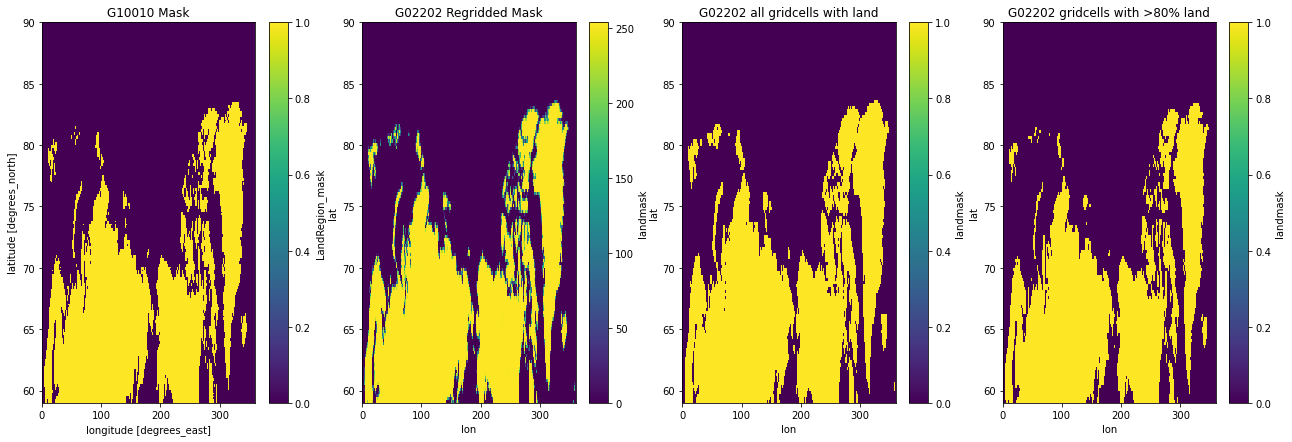

In [26]:
fig,axs = plt.subplots(1,4,figsize=(22,7))

(nsidc_seaice.sel(latitude=slice(None,59))['LandRegion_mask']==20).plot(ax=axs[0]) # mask on 0.25x0.25 deg grid from the g10010 product
axs[0].set_title('G10010 Mask')

g02202_ancillary_ds.sel(lat=slice(59,None))['landmask'].plot(ax=axs[1])
axs[1].set_title('G02202 Regridded Mask')
(g02202_ancillary_ds.sel(lat=slice(59,None))['landmask']>0).plot(ax=axs[2]) # reject all gridcell with any land, smoothes
axs[2].set_title('G02202 all gridcells with land')
(g02202_ancillary_ds.sel(lat=slice(59,None))['landmask']>200).plot(ax=axs[3]) # reject all gridcell with any land, smoothes
axs[3].set_title('G02202 gridcells with >80% land')


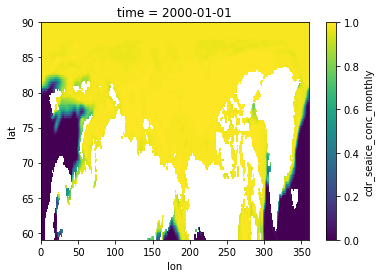

In [27]:
g02202_ds['cdr_seaice_conc_monthly'][0].sel(lat=slice(59,None)).plot()

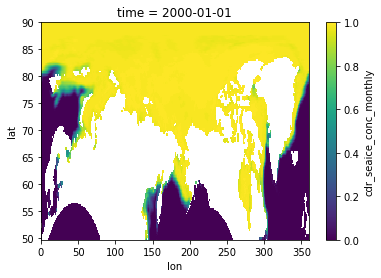

In [48]:
g02202_ds['cdr_seaice_conc_monthly'][0].plot()